In [1]:
import numpy as np
import pandas as pd
import json
import os

## Load latest execution full

In [2]:
full = pd.read_csv("Full/full_3.csv", index_col=0)
full = full.drop(['dram_read_bytes (dev_approximate_gravity)'], axis=1, errors='ignore')

/tmp/ipykernel_2774681/1990568059.py:1: DtypeWarning: Columns (58,76,78,100,153) have mixed types. Specify dtype option on import or set low_memory=False.
  full = pd.read_csv("Full/full_3.csv", index_col=0)


## Load selected Profiling features

In [3]:
selected_profiling_features = ['gld_transactions (dev_approximate_gravity)',
 'thread_inst_executed (dev_approximate_gravity)',
 'inst_compute_ld_st (correct_particles)',
 'active_warps_pm (correct_particles)',
 'global_store_requests (correct_particles)']

## Load selected input + GPU Features and target

In [4]:
# Define dataset and parameters
simulation_features = ['N', 'theta', 'dt'] 
gpu_features =  ['Clock Rate (MHz)', 'L2 Cache Size (KB)', 
                  'Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 
                  'Double Precision FLOP/s']

input_features = simulation_features + gpu_features
target_feature = 'exec_time_avg'

## Feature distribution analysis

### input analysis

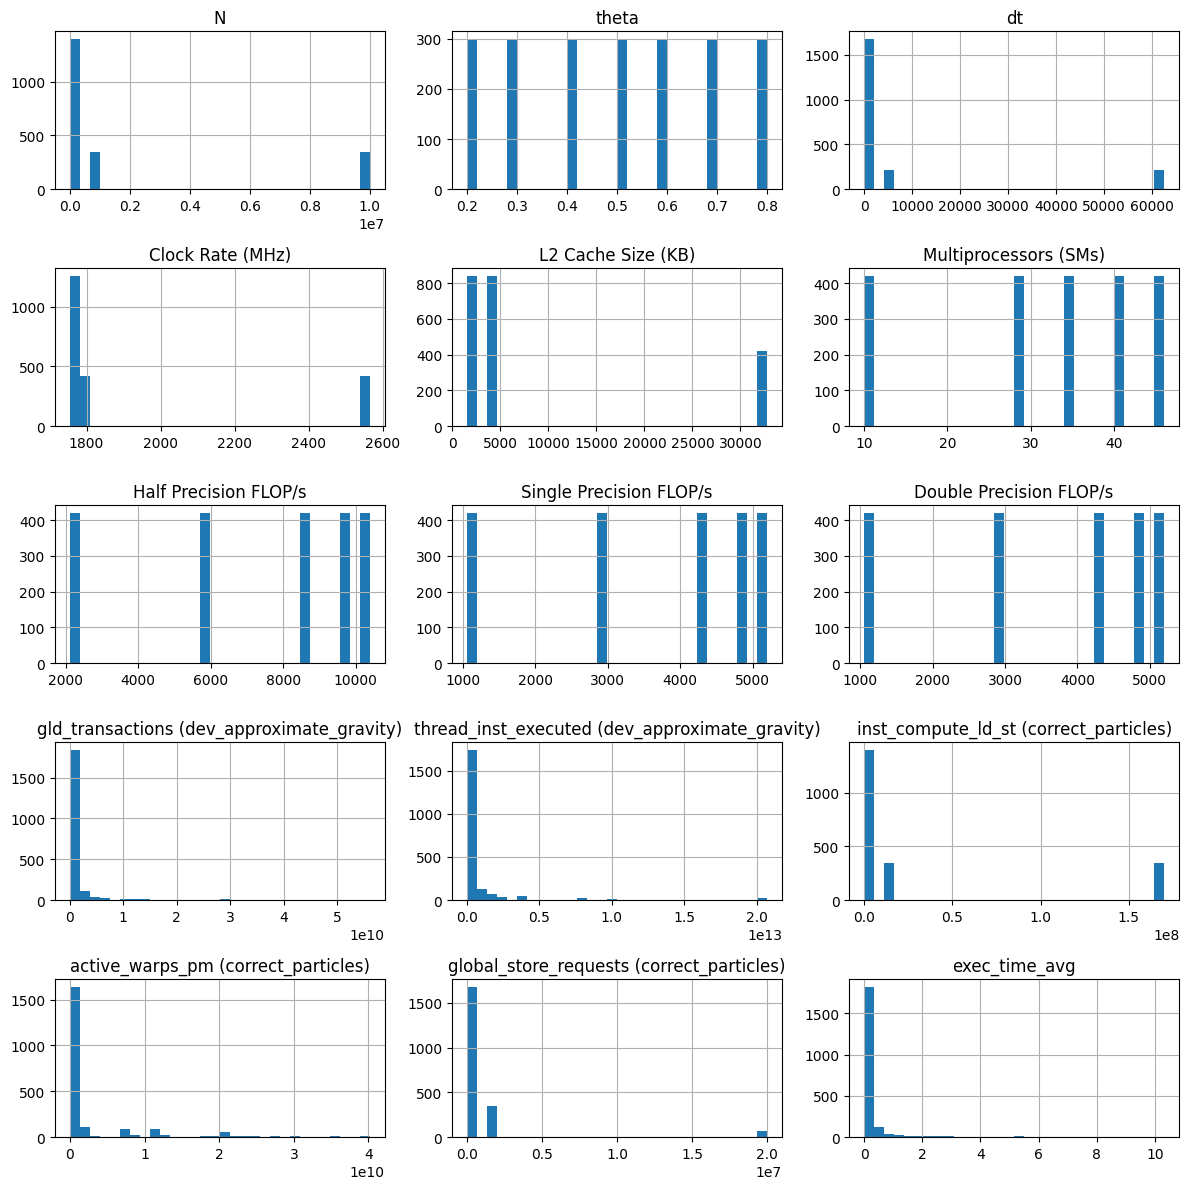

In [298]:
import matplotlib.pyplot as plt
full[input_features+selected_profiling_features+['exec_time_avg']].hist(layout=(5,3),bins=30, figsize=(12, 12))
plt.tight_layout()
plt.show()

In [314]:
# fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# # Plot the first histogram
# axes[0].hist(full['N'], bins=30)
# axes[0].set_xlabel('N')
# axes[0].set_ylabel('Frequency')
# axes[0].set_title('Histogram of N')

# # Plot the second histogram
# axes[1].hist(transformed_full_df['N'], bins=30)
# axes[1].set_xlabel('N')
# axes[1].set_ylabel('Frequency')
# axes[1].set_title('Transformed Histogram of N')

# plt.tight_layout()
# plt.show()

## Training tests

### test 1: intermediate model (Dtree->Dtree)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Split data for intermediate model training
X = full[input_features]
y_high_variance = full[selected_features]

# Train an intermediate model for each high-variance feature
intermediate_model = DecisionTreeRegressor()  # Using Linear Regression as an example
intermediate_model.fit(X, y_high_variance)

In [ ]:
# Generate high-variance feature predictions from the intermediate model
predicted_high_variance = intermediate_model.predict(X)
predicted_high_variance_df = pd.DataFrame(predicted_high_variance, columns=selected_features)

# Combine core features with the predicted high-variance features for main model training
X_full = pd.concat([X, predicted_high_variance_df], axis=1)
y_exec_time = full['exec_time_avg']

# Split data for main model training
X_train, X_test, y_train, y_test = train_test_split(X_full, y_exec_time, test_size=0.2, random_state=42)

# Train the main model with both core and high-variance features
main_model = DecisionTreeRegressor(random_state=42)
main_model.fit(X_train, y_train)


In [ ]:
# Predict high-variance features from the core input features in the test set
predicted_high_variance_test = intermediate_model.predict(X_test[input_features])
predicted_high_variance_test_df = pd.DataFrame(predicted_high_variance_test, columns=selected_features)

# Combine core inputs and predicted high-variance features for the final prediction
X_test_full = pd.concat([X_test[input_features].reset_index(drop=True), predicted_high_variance_test_df.reset_index(drop=True)], axis=1)

# Make final predictions
y_pred = main_model.predict(X_test_full)

# Display the results
results_df = pd.DataFrame({
    'N': X_test['N'],
    'theta': X_test['theta'],
    'dt': X_test['dt'],
    'Multiprocessors (SMs)': X_test['Multiprocessors (SMs)'],
    'Total Cores': X_test['Total Cores'],
    'L2 Cache Size (KB)': X_test['L2 Cache Size (KB)'],
    'y_pred': y_pred,
    'y_test': y_test
})

from sklearn.metrics import mean_absolute_percentage_error
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

print(results_df.to_csv())


### Test2: Direct model (sim + gpu, no high variance features)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Split data for intermediate model training
X_full = full[input_features]
y_exec_time = full['exec_time_avg']

# Split data for main model training
X_train, X_test, y_train, y_test = train_test_split(X_full, y_exec_time, test_size=0.2, random_state=42)

# Train the main model with both core and high-variance features
main_model = DecisionTreeRegressor(random_state=42)
main_model.fit(X_train, y_train)

# Make final predictions
y_pred = main_model.predict(X_test)

# Display the results
results_df = pd.DataFrame({
    'N': X_test['N'],
    'theta': X_test['theta'],
    'dt': X_test['dt'],
    'Multiprocessors (SMs)': X_test['Multiprocessors (SMs)'],
    'Total Cores': X_test['Total Cores'],
    'L2 Cache Size (KB)': X_test['L2 Cache Size (KB)'],
    'y_pred': y_pred,
    'y_test': y_test
})

from sklearn.metrics import mean_absolute_percentage_error
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

print(results_df.to_csv())


### Test3: Direct model (sim + gpu, no high variance features)

In [ ]:
selected_features

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import svm


# Split data for intermediate model training
X_full = full[input_features]
y_exec_time = full['exec_time_avg']

# Split data for main model training
X_train, X_test, y_train, y_test = train_test_split(X_full, y_exec_time, test_size=0.2, random_state=42)

# Train the main model with both core and high-variance features
main_model = DecisionTreeRegressor(random_state=42)
# main_model = LinearRegression() # Linear Kernel
main_model.fit(X_train, y_train)

# Make final predictions
y_pred = main_model.predict(X_test)

# Display the results
results_df = pd.DataFrame({
    'N': X_test['N'],
    'theta': X_test['theta'],
    'dt': X_test['dt'],
    'Multiprocessors (SMs)': X_test['Multiprocessors (SMs)'],
    'Total Cores': X_test['Total Cores'],
    'L2 Cache Size (KB)': X_test['L2 Cache Size (KB)'],
    'y_pred': y_pred,
    'y_test': y_test
})

from sklearn.metrics import mean_absolute_percentage_error
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

print(results_df.to_csv())


### Test 4: Multitask learning output using min, max and avg

In [4]:
# print(y_full.to_csv())

In [ ]:
input_features

In [ ]:
gpu_params

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comp():
    # Convert y_test and y_pred to DataFrames for easy plotting
    y_test_df = pd.DataFrame(y_test, columns=['exec_time_avg', 'exec_time_max', 'exec_time_min']).reset_index(drop=True)
    y_pred_df = pd.DataFrame(y_pred, columns=['exec_time_avg_pred', 'exec_time_max_pred', 'exec_time_min_pred'])

    # Reset index for test groups to match with y_test
    test_groups = groups.iloc[test_index].reset_index(drop=True)

    # Generate color mapping for each unique GPU name
    unique_gpus = test_groups.unique()
    palette = sns.color_palette("husl", len(unique_gpus))
    color_map = dict(zip(unique_gpus, palette))

    # Map colors for each GPU in the test set
    colors = test_groups.map(color_map)

    # Plot comparisons for each target variable
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Comparison of Actual vs Predicted Values (Color-coded by GPU)")

    target_names = ['exec_time_avg', 'exec_time_max', 'exec_time_min']
    for i, target in enumerate(target_names):
        scatter = axes[i].scatter(y_test_df[target], y_pred_df[f"{target}_pred"], c=colors, alpha=0.6)
        axes[i].plot([y_test_df[target].min(), y_test_df[target].max()],
                    [y_test_df[target].min(), y_test_df[target].max()], 'r--')  # Reference line
        axes[i].set_xlabel("Actual Values")
        axes[i].set_ylabel("Predicted Values")
        axes[i].set_title(f"{target} (Actual vs Predicted)")
        axes[i].grid(True)

    # Create a legend for GPU names
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[gpu], markersize=10) for gpu in unique_gpus]
    labels = unique_gpus
    fig.legend(handles, labels, title="GPU Name", loc="upper right")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Define input and target variables
X_full = full[selected_features]

a= ['N','theta','dt',
#  'Compute Capability',
#  'Total Memory (MB)',
 'Multiprocessors (SMs)',
 'Max Threads Per SM',
#  'Total Cores',
#  'Warp Size',
#  'Max Threads Per Block',
#  'Max Blocks Per SM',
#  'Shared Memory Per Block (KB)',
#  'Shared Memory Per SM (KB)',
#  'Registers Per Block',
#  'Registers Per SM',
#  'L1 Cache Size (KB)',
 'L2 Cache Size (KB)',
#  'Memory Bus Width (bits)',
#  'Memory Bandwidth (GB/s)',
#  'Clock Rate (MHz)',
 'Warps Per SM',
 'Blocks Per SM',
#  'Half Precision FLOP/s',
#  'Single Precision FLOP/s',
#  'Double Precision FLOP/s',
#  'Concurrent Kernels',
#  'Threads Per Warp',
#  'Global Memory Bandwidth (GB/s)',
#  'Global Memory Size (MB)',
#  'L2 Cache Size',
#  'Memcpy Engines'
 ]

y_full = full[['exec_time_avg', 'exec_time_max', 'exec_time_min']]  # Multi-output target

# Split data for main model training
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Train the main model with MultiOutputRegressor
base_model = DecisionTreeRegressor(random_state=42)
main_model = MultiOutputRegressor(base_model)
main_model.fit(X_train, y_train)

# Make predictions for each target (exec_time_avg, exec_time_max, exec_time_min)
y_pred = main_model.predict(X_test)

# Convert y_test and y_pred to DataFrames for easy comparison
y_test_df = pd.DataFrame(y_test, columns=['exec_time_avg', 'exec_time_max', 'exec_time_min']).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred, columns=['exec_time_avg_pred', 'exec_time_max_pred', 'exec_time_min_pred'])

# Display the results alongside input features
results_df = pd.concat([X_test.reset_index(drop=True), y_test_df, y_pred_df], axis=1)

# Calculate MAPE for each output
mape_avg = mean_absolute_percentage_error(y_test_df['exec_time_avg'], y_pred_df['exec_time_avg_pred'])
mape_max = mean_absolute_percentage_error(y_test_df['exec_time_max'], y_pred_df['exec_time_max_pred'])
mape_min = mean_absolute_percentage_error(y_test_df['exec_time_min'], y_pred_df['exec_time_min_pred'])

print(f"Mean Absolute Percentage Error (MAPE) - exec_time_avg: {mape_avg:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) - exec_time_max: {mape_max:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) - exec_time_min: {mape_min:.4f}")

# Export results to CSV (optional)
# print(results_df.to_csv(index=False))
plot_comp()


In [ ]:
# N,theta,dt,Multiprocessors (SMs),Max Threads Per SM,L2 Cache Size (KB),Warps Per SM,Blocks Per SM,


main_model.predict([[1000000,0.2,6.25e-05,40,1024,4096,32,16]])

In [ ]:
df_scaled = np.log1p(full[input_features].apply(pd.to_numeric, errors='coerce'))  # Use log1p to avoid issues with zero values (log(x+1))

# Step 2: Normalization (scaling between 0 and 1)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)

# print(df_normalized.to_csv())

In [ ]:
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# input_features = [
#  'N',
#  'theta',
#  'dt',
#  'Multiprocessors (SMs)',
#  'Max Threads Per SM',
# #  'L2 Cache Size (KB)',
#  'Warps Per SM',
# #  'Blocks Per SM',

# #  'Compute Capability',
# #  'Total Memory (MB)',
# #  'Total Cores',
# #  'Warp Size',
# #  'Max Threads Per Block',
# #  'Max Blocks Per SM',
# #  'Shared Memory Per Block (KB)',
# #  'Shared Memory Per SM (KB)',
# #  'Registers Per Block',
# #  'Registers Per SM',
# #  'L1 Cache Size (KB)',
# #  'Memory Bus Width (bits)',
# #  'Memory Bandwidth (GB/s)',
# #  'Clock Rate (MHz)',
# #  'Half Precision FLOP/s',
# #  'Single Precision FLOP/s',
# #  'Double Precision FLOP/s',
# #  'Concurrent Kernels',
# #  'Threads Per Warp',
# #  'Global Memory Bandwidth (GB/s)',
# #  'Global Memory Size (MB)',
# #  'L2 Cache Size',
# #  'Memcpy Engines'
#  ] #+ selected_features
input_features = ['N', 'theta', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']

# input_features = ['N', 'gld_transactions (dev_approximate_gravity)',
#  'thread_inst_executed (dev_approximate_gravity)',
#  'inst_compute_ld_st (correct_particles)',
#  'global_store_requests (correct_particles)']
# output_features = ['exec_time_avg', 'exec_time_max', 'exec_time_min']
output_features = ['exec_time_avg']

df_scaled = np.log1p(full[input_features].apply(pd.to_numeric, errors='coerce'))  # Use log1p to avoid issues with zero values (log(x+1))

# Step 2: Normalization (scaling between 0 and 1)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)


# Define input and target variables
# input_features = ['N', 'theta', 'dt', 'Multiprocessors (SMs)', 'Total Cores', 'L2 Cache Size (KB)']
# X_full = df_normalized[input_features]
sample_full = full #resample(full, n_samples=1000)
X_full = sample_full[input_features]
y_full = sample_full[output_features] # Multi-output target

# y_full = np.log10(full[['exec_time_avg', 'exec_time_max', 'exec_time_min']]) # Multi-output target
groups = sample_full['Name']  # Group by GPU name
# Apply square root transformation

# Initialize the model
# base_model = DecisionTreeRegressor(random_state=42) #,max_depth=15,max_features=1,max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=2)
# Best MAPE Score: 0.3368 , 0.2495

# base_model = SVR(kernel='rbf', C=0.001, epsilon=0.000001)  # You can tune 'C' and 'epsilon' for performance


# base_model = LinearRegression()
base_model = RandomForestRegressor(random_state = 42, bootstrap=True,max_depth=10,max_features=1)
main_model = MultiOutputRegressor(base_model)
# main_model = base_model

# Setup GroupKFold
group_kfold = GroupKFold(n_splits=groups.nunique())  # Define the number of splits

# Cross-validation with grouped folds
scores = []
for fold, (train_index, test_index) in enumerate(group_kfold.split(X_full, y_full, groups=groups), start=1):
    
    X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]
    y_train_root = np.power(y_train,(1/1))

    # Fit the model on the training set
    main_model.fit(X_train, y_train_root)
    
    # Predict on the test set
    y_pred_root = main_model.predict(X_test)
    y_pred = np.power(y_pred_root,1)
    
    y_test_df = pd.DataFrame(y_test, columns=output_features)
    y_pred_df = pd.DataFrame(y_pred, columns=output_features)

    # print(y_test_df)
    fold_mape = mean_absolute_percentage_error(y_test,y_pred)
    mape_avg = mean_absolute_percentage_error(y_test_df['exec_time_avg'], y_pred_df['exec_time_avg'])
    # mse_avg = mean_squared_error(y_test_df['exec_time_avg'], y_pred_df['exec_time_avg'])
    # mae_avg = mean_absolute_error(y_test_df['exec_time_avg'], y_pred_df['exec_time_avg'])
    # mape_min = 0# mean_absolute_percentage_error(y_test_df['exec_time_min'], y_pred_df['exec_time_min'])
    # mape_max = 0# mean_absolute_percentage_error(y_test_df['exec_time_max'], y_pred_df['exec_time_max'])
    
    scores.append(fold_mape)
    
    # Print the GPU names in the test set and the MAPE for this fold
    test_gpus = groups.iloc[test_index].unique()
    print(f"Fold {fold}: Test GPUs = {test_gpus}")
    print(f"Fold {fold}: MAPE = avg: {mape_avg:.4f}")
    # plot_comp()

# Calculate the average MAPE across folds
average_mape = np.mean(scores)
# print(scores)
print(f"Cross-Validated Mean Absolute Percentage Error (MAPE): {average_mape:.4f}")


In [ ]:
input_features = ['N', 'theta', 'Multiprocessors (SMs)','Half Precision FLOP/s', 'Single Precision FLOP/s', 
                  'Double Precision FLOP/s']
output_features = selected_features[0]

X_full = full[input_features]
# X_full['N_logN'] = full['N'] * np.log(full['N'])
y_full = np.power(full[output_features],1/2)

X_train, X_test, y_train, y_test, groups_train, groups_val = train_test_split(
    X_full, y_full, groups, test_size=0.2, random_state=42 #, stratify=groups
)

from sklearn.kernel_ridge import KernelRidge
# intermediate_model = KernelRidge(kernel='rbf', alpha=1.0)
from sklearn.ensemble import GradientBoostingRegressor
intermediate_model = GradientBoostingRegressor(max_depth=3,
                                n_estimators=1000,
                                learning_rate=0.1,
                                random_state=42)

intermediate_model.fit(X_train, y_train)
y_pred = intermediate_model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


In [ ]:
a = 1
b = []
for i in range(10):
    ins = [a*10**i,0.4,34,10396,5198,5198] 
    b.append(best_model.predict([ins])[0])
b

### Test 5: Linear interpolated model test

In [ ]:
full.query('dt == 0.0625 and N==100000 and `Clock Rate (MHz)` == 1785 and `L2 Cache Size (KB)` == 4096').plot(x='theta', y='exec_time_avg', marker='.')

In [1134]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Sample data
# Replace with your actual dataset
data = full

# pd.DataFrame({
#     'N': [...],
#     'dt': [...],
#     'theta': [...],
#     'Name': [...],
#     'exec_time_avg': [...]
# })

# Get unique combinations of dt, theta, and Name
combinations = data[['dt', 'theta', 'Clock Rate (MHz)','L2 Cache Size (KB)']].drop_duplicates()
models = {}

for _, row in combinations.iterrows():
    dt_val = row['dt']
    theta_val = row['theta']
    clock_rate_val = row['Clock Rate (MHz)']
    L2_cache_val = row['L2 Cache Size (KB)']
    # name_val = row['Name']

    # Filter the dataset based on the fixed combination
    subset = data.query('dt == @dt_val and theta == @theta_val and `Clock Rate (MHz)` == @clock_rate_val and `L2 Cache Size (KB)` == @L2_cache_val')

    # Fit a linear regression model for this subset
    if len(subset) > 1:  # Make sure there's enough data to fit
        model = ElasticNet()
        X = subset[['N']]
        y = subset['exec_time_avg']
        model.fit(X, y)

        # Store the model with a key identifying the fixed values
        models[(dt_val, theta_val, clock_rate_val,L2_cache_val)] = model


In [ ]:
def predict_exec_time_avg(N, dt, theta, clock_rate, L2_cache):
    # Find the corresponding model for the given dt, theta, and Name
    model_key = (dt, theta, clock_rate, L2_cache)
    model = models.get(model_key)
    
    if model:
        # Predict using the stored model for this combination
        return model.predict([[N]])[0]
    else:
        print("No model found for this combination.")
        return None

# Example usage
predicted_time = predict_exec_time_avg(N=100, dt=0.0625, theta=0.8, clock_rate= 1785, L2_cache = 4096)
print(f"Predicted execution time: {predicted_time}")

In [ ]:
full.query('N==100 and dt == 0.0625 and theta==0.8 and `Clock Rate (MHz)` == 1785 and `L2 Cache Size (KB)` == 4096')["exec_time_avg"]

In [1349]:
import numpy as np
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression

# Sample data
# Replace with your actual dataset
data = full

# Get unique combinations of dt, theta, Clock Rate, and L2 Cache Size
combinations = data[['dt', 'theta', 'Clock Rate (MHz)', 'L2 Cache Size (KB)']].drop_duplicates()
models = {}
combination_keys = []

# Fit linear models for each unique combination of (dt, theta, Clock Rate, L2 Cache Size)
for _, row in combinations.iterrows():
    dt_val = row['dt']
    theta_val = row['theta']
    clock_rate_val = row['Clock Rate (MHz)']
    L2_cache_val = row['L2 Cache Size (KB)']

    # Filter the dataset based on the fixed combination
    subset = data.query('dt == @dt_val and theta == @theta_val and `Clock Rate (MHz)` == @clock_rate_val and `L2 Cache Size (KB)` == @L2_cache_val')

    # Fit a linear regression model for this subset
    if len(subset) > 1:  # Ensure there's enough data to fit
        # model = ElasticNet()
        model =  make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

        X = subset[['N']]
        y = subset['exec_time_avg']
        model.fit(X, y)

        # Store the model and corresponding feature combination for interpolation
        models[(dt_val, theta_val, clock_rate_val, L2_cache_val)] = model
        combination_keys.append((dt_val, theta_val, clock_rate_val, L2_cache_val))

# # Save models to disk (optional) using joblib or pickle
# import joblib
# joblib.dump(models, 'saved_models.pkl')


In [ ]:

# # Load the saved models
# models = joblib.load('saved_models.pkl')

def query_prediction(N, dt, theta, clock_rate, L2_cache):
    # Find the closest match to the requested combination
    combination_key = (dt, theta, clock_rate, L2_cache)
    # If the combination exists in the saved models
    if combination_key in models:
        model = models[combination_key]
        return model.predict([[N]])[0]  # Predict using the model for this combination
    else:
        print("Combination not found. Using interpolation.")
        
        # Perform interpolation using griddata if no exact match is found
        combination_keys = np.array(list(models.keys()))  # Get known combinations
        known_predictions = []
        
        # Get predictions for all known combinations
        for comb_key in combination_keys:
            model = models[tuple(comb_key)]
            known_predictions.append(model.predict([[N]])[0])
        
        print(combination_keys)
        # Interpolate predictions for the new combination
        interpolated_value = griddata(combination_keys, known_predictions, np.array([[dt, theta, clock_rate,L2_cache]]), method='linear')
        print(interpolated_value)
        return interpolated_value[0] if interpolated_value.size > 0 else None

# Example usage
predicted_time = query_prediction(N=10000000, dt=0.0625, theta=0.8, clock_rate= 1785, L2_cache = 1096)
print(f"Predicted execution time: {predicted_time}")

In [ ]:
full.query('N==10000000 and dt == 0.0625 and theta==0.2 and `Clock Rate (MHz)` == 1785 and `L2 Cache Size (KB)` == 4096')["exec_time_avg"]

In [ ]:
print(full['Multiprocessors (SMs)'])

### Test 6: CV tree and svr test1

In [ ]:
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Define input and target variables
input_features = ['N', 'theta', 'Multiprocessors (SMs)','Half Precision FLOP/s', 'Single Precision FLOP/s', 
                  'Double Precision FLOP/s'] # + selected_features

# input_features = ['N', 'theta','dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)','Multiprocessors (SMs)','Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']

output_features = ['exec_time_avg']
grouping_feature = 'Name'

f_full = full
# output_features = selected_features
# X_full = pd.concat([full[input_features], np.power(full[selected_features[0]],1/10)], axis=1) 
X_full = f_full[input_features]

# X_full = pd.concat([full[input_features], pd.DataFrame(intermediate_model.predict(full[input_features]),columns=[selected_features[0]])], axis=1) 
# y_full = np.power(full[output_features],1/10)
y_full = f_full[output_features]
groups = f_full[grouping_feature]  # Group by GPU name

# Step 1: Split data into training and validation sets
X_train, X_val, y_train, y_val, groups_train, groups_val = train_test_split(
    X_full, y_full, groups, test_size=0.2, random_state=42, stratify=groups
)

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)

# Step 2: Initialize the base model and define the parameter grid
base_model_rf = RandomForestRegressor(random_state=42)
base_model_svr = SVR()
base_model_poly = Pipeline([
                    ('poly', PolynomialFeatures()),   # PolynomialFeatures step
                    ('ridge', Ridge())                # Ridge regression step
                ])
base_model_krr = KernelRidge()
base_model_gb = GradientBoostingRegressor(random_state=42)
base_model_elasticnet = ElasticNet(random_state=42)
base_model_mlp = MLPRegressor(random_state=42)
base_model_etr = ExtraTreesRegressor(random_state=42)

param_distributions_rf = {
    'estimator__n_estimators': [1,5,10,25,50, 100, 200],
    'estimator__max_depth': [2,5,10, 20, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1,2, 4,6],
    'estimator__max_features': [1, 'sqrt', 'log2']
}

param_distributions_etr = {
    'estimator__n_estimators': [50, 100, 200, 300],        # Number of trees in the forest
    'estimator__max_depth': [None, 10, 20, 30],            # Maximum depth of the trees
    'estimator__min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['sqrt', 'log2', None],     # Number of features to consider when looking for the best split
    'estimator__bootstrap': [True, False],                 # Whether bootstrap samples are used when building trees
}

param_distributions_svr = {
    'estimator__C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'estimator__epsilon': [0.0001, 0.001, 0.01, 0.1, 0.5],  # Margin of error
    'estimator__kernel': ['rbf'],  # Kernel types
    #'estimator__degree': [2, 3, 4],  # Only for 'poly' kernel
    'estimator__gamma': ['scale', 'auto'],  # Kernel coefficient
}

param_distributions_poly = {
    'poly__degree': [2, 3, 4, 5],                  # Degree of polynomial features
    'ridge__alpha': [0.1, 1, 10, 100, 1000],       # Regularization parameter for Ridge
    'ridge__fit_intercept': [True, False],         # Whether to fit the intercept term
    'ridge__normalize': [True, False],             # Normalize inputs
}

param_distributions_krr = {
    'estimator__alpha': [0.1, 1, 10, 100, 1000],  # Regularization strength
    'estimator__kernel': ['rbf', ],  # Kernel types
    # 'estimator__degree': [2, 3, 4],  # Degree of polynomial kernel (only used if kernel='polynomial')
    'estimator__gamma': [0.01,0.1,1,None],  # Kernel coefficient for 'rbf' and 'sigmoid'
}

param_distributions_gb = {
    'estimator__n_estimators': [50, 100, 200, 500],  # Number of boosting stages
    'estimator__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
    'estimator__max_depth': [3, 5, 7, 10],  # Maximum depth of each estimator
    'estimator__min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum samples required in leaf nodes
    'estimator__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per estimator
    'estimator__max_features': [1, 'sqrt', 'log2']  # Number of features to consider at each split
}

param_distributions_elasticnet = {
    'estimator__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'estimator__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0,],  # Mix between L1 and L2 (lasso and ridge)
    'estimator__fit_intercept': [True, False],  # Whether to calculate the intercept
    'estimator__max_iter': [100000],  # Whether to calculate the intercept
}

param_distributions_mlp = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100, 50)],  # Different hidden layer configurations
    'estimator__activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'estimator__solver': ['adam', 'sgd'],  # Optimization algorithms
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 regularization term
    'estimator__learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'estimator__learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'estimator__max_iter': [200, 300, 500]  # Number of epochs
}

base_model = base_model_etr
param_distributions = param_distributions_etr
#{'model__estimator__max_depth': [None], 'model__estimator__max_features': [1], 'model__estimator__min_samples_leaf': [1], 'model__estimator__min_samples_split': [2], 'model__estimator__n_estimators': [10]}
 #param_distributions_gb

# Step 3: Set up MultiOutputRegressor with RandomizedSearchCV on training set
main_model = MultiOutputRegressor(base_model)
# int_mod = Pipeline([
#     ('quantile_transform', quantile_transformer),  # Step to transform target
#     ('model', base_model)
# ])

# main_model = TransformedTargetRegressor(
#     # regressor=MultiOutputRegressor(base_model),
#     regressor=int_mod,
#     transformer=quantile_transformer
# )


group_kfold = GroupKFold(n_splits=min(5, groups_train.nunique()))  # Number of splits limited to unique group count

random_search = GridSearchCV(
    estimator=main_model,
    param_grid=param_distributions,
    # n_iter=100,  # Adjust based on computational resources
    cv=group_kfold.split(X_train, y_train, groups=groups_train),
    scoring='neg_mean_absolute_percentage_error',
    # random_state=42,
    n_jobs=-1
)

# Step 4: Fit the RandomizedSearchCV on the training data only
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding MAPE score
best_mape = -random_search.best_score_  # Convert to positive MAPE
print(f"Best MAPE Score: {best_mape:.4f}")
print("Best Parameters:", random_search.best_params_)


# Step 5: Use the best parameters to fit a final model and evaluate on validation set
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
# Store the MAPE scores for each fold along with group names
fold_scores = []
group_names = []

# Loop through each fold, get the groups and MAPE score
for train_index, test_index in group_kfold.split(X_train, y_train, groups=groups_train):
    # Get group names for the test set in this fold
    test_group_names = groups_train.iloc[test_index].unique()
    group_names.append(test_group_names)

    # Train on the best model and compute the score for this fold
    best_model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = best_model.predict(X_train.iloc[test_index])
    fold_mape = mean_absolute_percentage_error(y_train.iloc[test_index], y_pred)

    # Store the score
    fold_scores.append(fold_mape)

# Print results with group names
for fold_idx, (score, group) in enumerate(zip(fold_scores, group_names), start=1):
    print(f"Fold {fold_idx} (Groups: {group}): MAPE = {score:.4f}")

# Calculate and print the mean MAPE across all folds
mean_mape = np.mean(fold_scores)
print(f"Mean MAPE across all folds: {mean_mape:.4f}")


X_val_truth = X_val
# X_val_truth = pd.concat([X_val[input_features].reset_index(drop=True), pd.DataFrame(intermediate_model.predict(X_val[input_features]),columns=[selected_features[0]]).reset_index(drop=True)],axis=1)

y_val_pred = best_model.predict(X_val_truth)

# Calculate and display the MAPE for the validation set
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Final Validation MAPE with Best Parameters: {mape_val:.4f}")
# print("Best Parameters from Randomized Search:", random_search.best_params_)


### Test 7: CV whole model test

In [ ]:
full.query('dt == 0.625 and theta == 0.2 and N == 1000000')

In [ ]:
f_full = full # .query('dt <= 625') # filter dt more than 65 theta == 0.8  and Name == "NVIDIA GeForce GTX 1060 6GB" and theta <= 0.4 
f_full.shape

In [ ]:
f_full

In [ ]:
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Define input and target variables
# input_features = ['N', 'theta', 'dt', 'Multiprocessors (SMs)','Half Precision FLOP/s', 'Single Precision FLOP/s', 
#                   'Double Precision FLOP/s'] # + selected_features

input_features = ['N','theta']

# input_features = ['N', 'theta','dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)','Multiprocessors (SMs)','Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']

output_features = ['exec_time_avg']
grouping_feature = 'Name'

# f_full = full.query('dt == 0.625 and theta <= 0.8 and N == 1000000') # filter dt more than 65

# output_features = selected_features
# X_full = pd.concat([full[input_features], np.power(full[selected_features[0]],1/10)], axis=1) 
X_full = f_full[input_features]

# X_full = pd.concat([full[input_features], pd.DataFrame(intermediate_model.predict(full[input_features]),columns=[selected_features[0]])], axis=1) 
# y_full = np.power(full[output_features],1/10)
y_full = f_full[output_features]
# groups = f_full[grouping_feature]  # Group by GPU name

# Step 1: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42 #,  stratify=groups
)

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)

# Step 2: Initialize the base model and define the parameter grid
base_model_rf = RandomForestRegressor(random_state=42)
base_model_svr = SVR()
base_model_poly = Pipeline([
                    ('poly', PolynomialFeatures()),   # PolynomialFeatures step
                    ('ridge', Ridge())                # Ridge regression step
                ])
base_model_krr = KernelRidge()
base_model_gb = GradientBoostingRegressor(random_state=42)
base_model_elasticnet = ElasticNet(random_state=42)
base_model_mlp = MLPRegressor(random_state=42)
base_model_etr = ExtraTreesRegressor(random_state=42)

param_distributions_rf = {
    'estimator__n_estimators': [1,5,10,25,50, 100, 200],
    'estimator__max_depth': [2,5,10, 20, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1,2, 4,6],
    'estimator__max_features': [1, 'sqrt', 'log2']
}

param_distributions_etr = {
    'estimator__n_estimators': [50, 100, 200, 300],        # Number of trees in the forest
    'estimator__max_depth': [None, 10, 20, 30],            # Maximum depth of the trees
    'estimator__min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['sqrt', 'log2', None],     # Number of features to consider when looking for the best split
    'estimator__bootstrap': [True, False],                 # Whether bootstrap samples are used when building trees
}

param_distributions_svr = {
    'estimator__C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'estimator__epsilon': [0.0001, 0.001, 0.01, 0.1, 0.5],  # Margin of error
    'estimator__kernel': ['rbf'],  # Kernel types
    #'estimator__degree': [2, 3, 4],  # Only for 'poly' kernel
    'estimator__gamma': ['scale', 'auto'],  # Kernel coefficient
}

param_distributions_poly = {
    'poly__degree': [2, 3, 4, 5],                  # Degree of polynomial features
    'ridge__alpha': [0.1, 1, 10, 100, 1000],       # Regularization parameter for Ridge
    'ridge__fit_intercept': [True, False],         # Whether to fit the intercept term
    'ridge__normalize': [True, False],             # Normalize inputs
}

param_distributions_krr = {
    'estimator__alpha': [0.1, 1, 10, 100, 1000],  # Regularization strength
    'estimator__kernel': ['rbf', ],  # Kernel types
    # 'estimator__degree': [2, 3, 4],  # Degree of polynomial kernel (only used if kernel='polynomial')
    'estimator__gamma': [0.01,0.1,1,None],  # Kernel coefficient for 'rbf' and 'sigmoid'
}

param_distributions_gb = {
    'estimator__n_estimators': [50, 100, 200, 500],  # Number of boosting stages
    'estimator__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
    'estimator__max_depth': [3, 5, 7, 10],  # Maximum depth of each estimator
    'estimator__min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum samples required in leaf nodes
    'estimator__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per estimator
    'estimator__max_features': [1, 'sqrt', 'log2']  # Number of features to consider at each split
}

param_distributions_elasticnet = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0,],  # Mix between L1 and L2 (lasso and ridge)
    'model__fit_intercept': [True, False],  # Whether to calculate the intercept
    'model__max_iter': [100000],  # Whether to calculate the intercept
}

param_distributions_mlp = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100, 50)],  # Different hidden layer configurations
    'estimator__activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'estimator__solver': ['adam', 'sgd'],  # Optimization algorithms
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 regularization term
    'estimator__learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'estimator__learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'estimator__max_iter': [200, 300, 500]  # Number of epochs
}


# PARAMS

base_model = base_model_elasticnet
param_distributions = param_distributions_elasticnet


#{'model__estimator__max_depth': [None], 'model__estimator__max_features': [1], 'model__estimator__min_samples_leaf': [1], 'model__estimator__min_samples_split': [2], 'model__estimator__n_estimators': [10]}
 #param_distributions_gb

# Step 3: Set up MultiOutputRegressor with RandomizedSearchCV on training set
# main_model = MultiOutputRegressor(base_model)

# main_model = MultiOutputRegressor(base_model)

main_model = Pipeline([
    ('quantile_transform', quantile_transformer),  # Step to transform target
    ('model', base_model)
])

# main_model = TransformedTargetRegressor(
#     # regressor=MultiOutputRegressor(base_model),
#     regressor=int_mod,
#     transformer=quantile_transformer
# )


# group_kfold = GroupKFold(n_splits=min(5, groups_train.nunique()))  # Number of splits limited to unique group count

random_search = RandomizedSearchCV(
    estimator=main_model,
    # param_grid=param_distributions,
    param_distributions=param_distributions,
    n_iter=100,  # Adjust based on computational resources
    # cv=group_kfold.split(X_train, y_train, groups=groups_train),
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    n_jobs=-1
)

# Step 4: Fit the RandomizedSearchCV on the training data only
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding MAPE score
best_mape = -random_search.best_score_  # Convert to positive MAPE
print(f"Best MAPE Score: {best_mape:.4f}")
print("Best Parameters:", random_search.best_params_)


# Step 5: Use the best parameters to fit a final model and evaluate on validation set
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
# Store the MAPE scores for each fold along with group names
fold_scores = []
# group_names = []

X_val_truth = X_val
# X_val_truth = pd.concat([X_val[input_features].reset_index(drop=True), pd.DataFrame(intermediate_model.predict(X_val[input_features]),columns=[selected_features[0]]).reset_index(drop=True)],axis=1)

y_val_pred = best_model.predict(X_val_truth)

# Calculate and display the MAPE for the validation set
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Final Validation MAPE with Best Parameters: {mape_val:.4f}")
# print("Best Parameters from Randomized Search:", random_search.best_params_)


### Test 8: Tester transforms

In [ ]:
# example of normalizing input and output variables for regression.
from numpy import mean
from numpy import absolute
from numpy import loadtxt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import MinMaxScaler,PowerTransformer,FunctionTransformer,QuantileTransformer,StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# split into inputs and outputs
X, y = f_full[['N', 'theta', 'dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)','Multiprocessors (SMs)' , 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']], f_full['exec_time_avg']
# prepare the model with input scaling
pipeline = Pipeline(steps=[('normalize', PowerTransformer()), ('model', RandomForestRegressor(min_samples_split=10,min_samples_leaf=6,n_estimators=100,max_depth=20,max_features=0.2))]) # CHECK: SVR(kernel='rbf',C=0.1,epsilon=0.0001) HuberRegressor(alpha=0.01,epsilon=1.5)
# prepare the model with target scaling
model = TransformedTargetRegressor(regressor=pipeline, transformer=QuantileTransformer())
# evaluate model
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# convert scores to positive
scores = absolute(scores)
# summarize the result
s_mean = mean(scores)
print('Mean MAE: %.3f' % (s_mean))

cv2 = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv2, n_jobs=-1)
# convert scores to positive
scores = absolute(scores)
# summarize the result
s_mean = mean(scores)
print('Mean MAPE: %.3f' % (s_mean))

In [ ]:
print(X_full.to_string())

In [ ]:

import numpy as np
from sklearn.preprocessing import PowerTransformer

x = f_full[['Clock Rate (MHz)']]
print(x.describe())
# [Issue #1]
# RuntimeWarning: overflow encountered in multiply from `x_trans_var = x_trans.var()`
s = PowerTransformer(method="yeo-johnson", standardize=False).fit_transform(x)
s = StandardScaler()
print(s)


### Test 9: Second attempt cv preprocessing

In [ ]:
# from numpy import mean, absolute
# from itertools import combinations
# from sklearn.model_selection import KFold,GroupKFold, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import HuberRegressor
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer, MinMaxScaler, FunctionTransformer
# from sklearn.compose import TransformedTargetRegressor
# from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
# import pandas as pd

# # Split the dataset
# X_full = f_full[['N', 'theta', 'dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)','Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']] #'Multiprocessors (SMs)','Half Precision FLOP/s', 'Single Precision FLOP/s',                   'Double Precision FLOP/s']]
# y = f_full['exec_time_avg']
# groups = f_full['Name']  # The column used for grouping

# # Generate all feature subsets
# feature_subsets = []
# for r in range(1, len(X_full.columns) + 1):  # r = subset size (1 to len(columns))
#     feature_subsets.extend(combinations(X_full.columns, r))

# # feature_subsets = [['N', 'theta', 'dt'], ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)','Multiprocessors (SMs)' , 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']]

# # Define hyperparameters for the model
# model_params = {
#     'regressor__model__epsilon': [1.35, 1.5, 1.75],
#     'regressor__model__alpha': [0.0001, 0.001, 0.01],
# }

# # Custom GridSearchCV to handle feature subsets
# results = []

# # cv = KFold(n_splits=10, shuffle=True, random_state=1)
# # cv = GroupKFold(n_splits=5)  # Adjust the number of splits if needed

# scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
# scorer_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# ## Split CV
# cv_split = KFold(n_splits=10, shuffle=True, random_state=1)

# ## GPU group CV
# cv_GPU = GroupKFold(n_splits=5)  # Adjust the number of splits if needed

# # Iterate over feature subsets
# for features in feature_subsets:
#     # Subset the input data
#     X = X_full[list(features)]
    
#     # Define the model (with pipelines if needed)
#     pipeline = Pipeline(steps=[
#         ('normalize', PowerTransformer()), 
#         ('model', HuberRegressor())
#     ])
    
#     # Use a TransformedTargetRegressor if output transformation is needed
#     model = TransformedTargetRegressor(
#         regressor=pipeline, 
#         transformer=QuantileTransformer()
#     )
    
    
#     # Create a GridSearchCV object with GroupKFold
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=model_params,  # Parameter grid to search
#         scoring={'MAE': scorer_mae, 'MAPE': scorer_mape},  # Multiple metrics
#         refit='MAPE',  # Optimize based on MAE

#         ## Split CV
#         # cv=cv_split,

#         ## GPU Group CV
#         cv=cv_GPU.split(X, y, groups), 
        
#         n_jobs=-1  # Use all available cores
#     )
    
#     # Fit the GridSearchCV object
#     grid_search.fit(X, y)
    
#     # Store results
#     results.append({
#         'features': features,
#         'best_params': grid_search.best_params_,
#         'best_mae': -grid_search.best_score_,  # Convert back to positive since MAE is negative
#         'best_mape': -grid_search.cv_results_['mean_test_MAPE'][grid_search.best_index_],  # Same for MAPE
#     })

# # Find the best result
# best_result = min(results, key=lambda x: x['best_mae'])
 
# # Display results
# print("Best feature subset:", best_result['features'])
# print("Best parameters:", best_result['best_params'])
# print("Best MAE:", best_result['best_mae'])
# print("Best MAPE:", best_result['best_mape'])

## Cross Validation training

### Transformers

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import matplotlib.pyplot as plt

# Define named functions for the transformations
def log10_transform(x):
    return np.log10(x)

def inverse_log10_transform(x):
    return np.power(10, x)

# Define named functions for the transformations
def log2_transform(x):
    return np.log2(x)

def inverse_log2_transform(x):
    return np.power(2, x)

# Define the sequential transformer 
log10_scale_transformer = Pipeline(steps=[
    ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform)),  # Apply log10
    ('scaler', StandardScaler()),
])

# Define the sequential transformer 
log_scale_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),  # Apply log10
    ('scaler', StandardScaler()),
])

### Pipeline generator (scaled and transformed)

In [99]:
# 'Clock Rate (MHz)' StandardScaler probs
# 'Multiprocessors (SMs)' StandardScaler
# 'Half Precision FLOP/s', StandardScaler
# 'Single Precision FLOP/s', StandardScaler
# 'Double Precision FLOP/s', StandardScaler
# 'gld_transactions (dev_approximate_gravity)', log10_scale_transformer
# 'thread_inst_executed (dev_approximate_gravity)', log10_scale_transformer
# 'inst_compute_ld_st (correct_particles)', log10_scale_transformer
# 'active_warps_pm (correct_particles)', log10_scale_transformer
# 'global_store_requests (correct_particles)' log10_scale_transformer
# 'exec_time_avg' log10_scale_transformer

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer

# Define the transformer for N and theta columns
def CreatePipelineModel(model,input_parameters):
    
    # Apply defined transforms available input columns columns
    transformer = ColumnTransformer(
        transformers=[
            ('scale', StandardScaler(), list(set(input_parameters) & set(['theta','Clock Rate (MHz)','Multiprocessors (SMs)','L2 Cache Size (KB)',
                                                                          'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']))),
            ('log10', FunctionTransformer(func=log10_transform, inverse_func=inverse_log10_transform),list(set(input_parameters) & set(['I']))),  # Apply log10
            ('log', FunctionTransformer(func=np.log, inverse_func=np.exp), list(set(input_parameters) & set(['dt']))),
            ('log10scale', log10_scale_transformer, list(set(input_parameters) & set(   ['N','gld_transactions (dev_approximate_gravity)',
                                                                                        'thread_inst_executed (dev_approximate_gravity)',
                                                                                        'inst_compute_ld_st (correct_particles)', 
                                                                                        'active_warps_pm (correct_particles)',
                                                                                        'global_store_requests (correct_particles)'])))
        ],
        remainder='passthrough'  # Pass through the remaining columns as they are
    )

    # Define the model pipeline
    pipeline = Pipeline(steps=[
        ('normalize', transformer), 
        ('model', model) 
    ])

    # Wrap with TransformedTargetRegressor
    pipelined_model = TransformedTargetRegressor(
        regressor=pipeline, 
        transformer=log_scale_transformer
    )

    return pipelined_model

### Validate transformed distributions

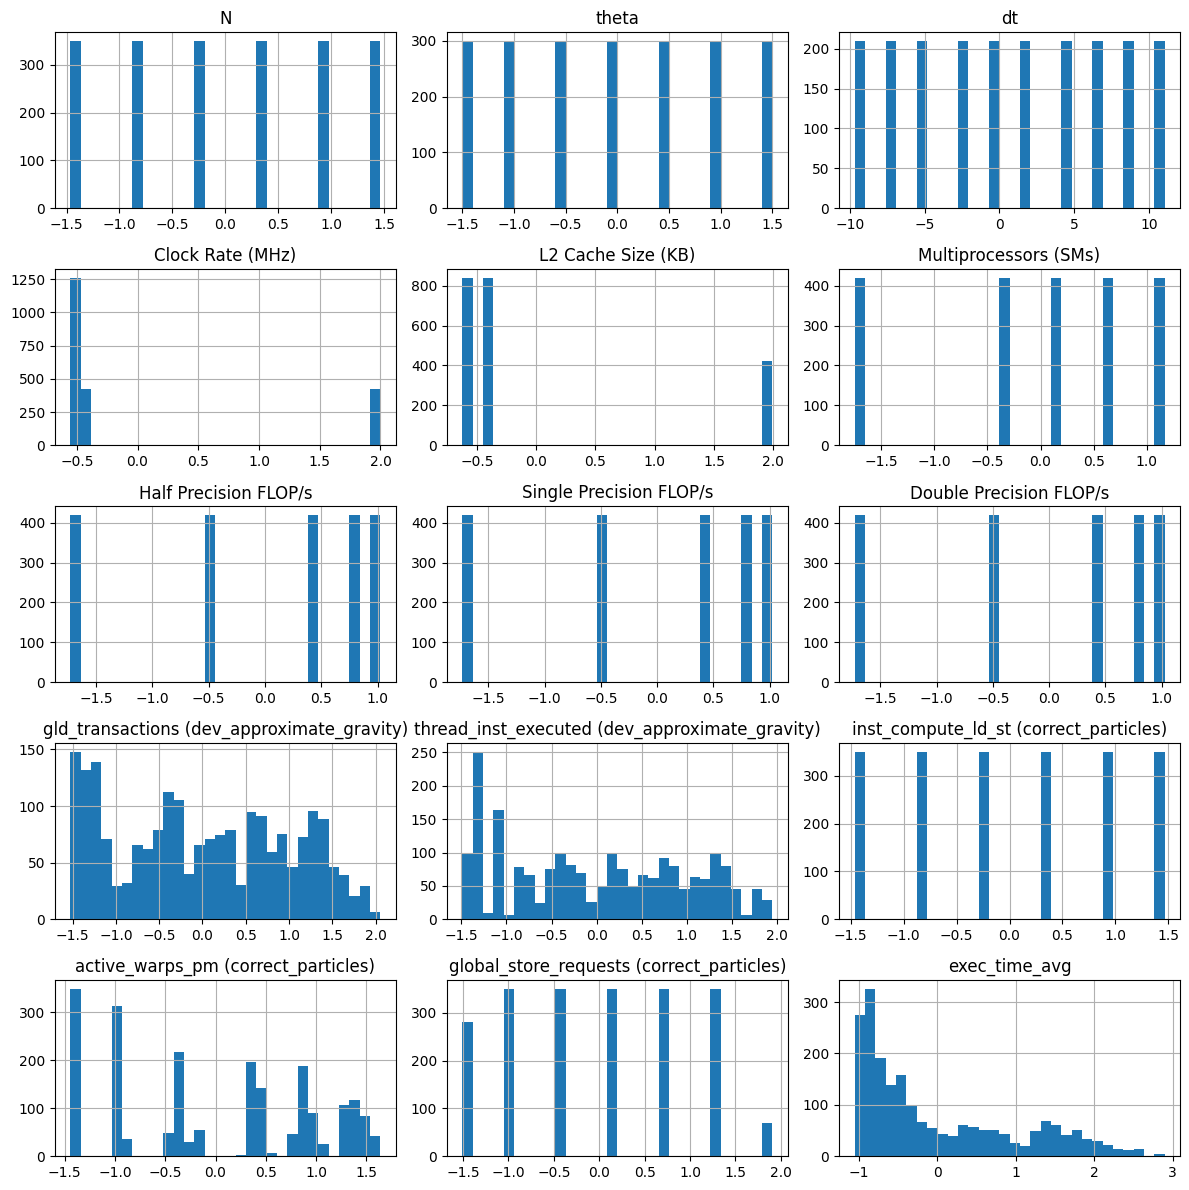

In [307]:
import matplotlib.pyplot as plt

# Create the pipeline model
input_parameters = input_features+selected_profiling_features
pipeline_model = CreatePipelineModel(input_parameters=input_parameters, model=HuberRegressor())

# Apply the transformations to the full DataFrame
transformed_full = pipeline_model.regressor.named_steps["normalize"].fit_transform(full[input_parameters])
transformed_columns = [feature for t_ in pipeline_model.regressor.named_steps["normalize"].transformers_ for feature in t_[-1]]
transformed_full_df = pd.DataFrame(transformed_full, columns=transformed_columns).reindex(columns=input_parameters)
transformed_target = pd.DataFrame(pipeline_model.transformer.fit_transform(full[[target_feature]]), columns=full[[target_feature]].columns)
transformed_full_df = pd.concat([transformed_full_df, transformed_target], axis=1)

# Plot the resulting histograms for the transformed features
transformed_full_df.hist(layout=(5,3),bins=30, figsize=(12, 12))
plt.tight_layout()
plt.show()

In [206]:
transformed_full_df['N'].describe()

count    2.100000e+03
mean     8.120488e-17
std      1.000238e+00
min     -1.729728e+00
25%     -4.598734e-01
50%      3.977769e-01
75%      7.674308e-01
max      1.024393e+00
Name: N, dtype: float64

### Wrapped Cross Validation Grid Search Trainer

In [8]:
from numpy import mean, absolute
from itertools import combinations
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
from IPython.display import clear_output
import os

def run_feature_subset_cv(
    f_full, 
    input_features, 
    target_feature, 
    model, 
    model_params, 
    extra_features=[], 
    use_gpu_cv=False,
    use_feature_subsets=True, 
    refit_error='MAPE', #MAPE OR MAE
    output_folder="CV_results"
):
    
    # Prepare input and target
    X_full = f_full[input_features+extra_features]
    y = f_full[target_feature]
    groups = f_full['Name'] if use_gpu_cv else None  # Use 'Name' for GroupKFold if applicable

    # Generate feature subsets or use all features
    if use_feature_subsets:
        feature_subsets = []
        for r in range(1, len(X_full[input_features].columns) + 1):  # r = subset size (1 to len(columns))
            feature_subsets.extend(combinations(X_full[input_features].columns, r))
    else:
        feature_subsets = [input_features]  # Use all input features as one subset
    
    # Define cross-validation strategy
    cv = GroupKFold(n_splits=5) if use_gpu_cv else KFold(n_splits=10, shuffle=True, random_state=1)

    # Define scoring metrics
    scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
    scorer_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    # Store results
    results = []
    
    # Precompute the pipeline models
    precomputed_models = [
        CreatePipelineModel(input_parameters=list(features) + extra_features, model=model)
        for features in feature_subsets
    ]

    print(f"Testing {len(feature_subsets)} feature subset(s)...")
    with tqdm(total=len(feature_subsets), desc="Progress", unit="subset") as pbar, \
         tqdm(total=len(feature_subsets), desc="Custom Text", unit="update") as text_pbar:
                # Iterate over feature subsets
        for idx, features in enumerate(feature_subsets):
            # Subset the input data
            X = X_full[list(features)+extra_features]

            # Access the precomputed pipeline model by index
            pipelined_model = precomputed_models[idx]

            # Create GridSearchCV object
            grid_search = GridSearchCV(
                estimator=pipelined_model,
                param_grid=model_params,
                scoring={'MAE': scorer_mae, 'MAPE': scorer_mape},
                refit=refit_error,  # Optimize based on MAPE
                cv=cv.split(X, y, groups) if use_gpu_cv else cv,
                verbose=0,
                n_jobs=20 # -1  # Use all available cores
            )

            # Fit GridSearchCV
            grid_search.fit(X, y)

            # Append results
            results.append({
                'features': list(features)+extra_features,
                'best_params': grid_search.best_params_,
                'best_mae': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],
                'best_mape': -grid_search.cv_results_['mean_test_MAPE'][grid_search.best_index_]
            })
            
            pbar.set_postfix({"current_subset": str(list(features)+extra_features), "current_mae": round(results[-1]['best_mae'], 3),"current_mape": round(results[-1]['best_mape'], 3)})
            text_pbar.set_description_str(
                f"> best_mae:{round(min(results, key=lambda x: x['best_mae'])['best_mae'], 3)}\n"+
                f"> best_mape:{round(min(results, key=lambda x: x['best_mape'])['best_mape'], 3)}\n"+
                f"> best_params:{min(results, key=lambda x: x['best_mape'])['best_params']}\n"+
                f"> best_features:{min(results, key=lambda x: x['best_mape'])['features']}")
            pbar.update(1)
            text_pbar.update(1)

    # Find the best result
    best_result = min(results, key=lambda x: x['best_mape'])
    
    # Extract the model name from the pipeline
    model_name = pipelined_model.regressor.steps[-1][1].__class__.__name__

    # Determine CV type for the filename
    cv_type = "GPU_CV" if use_gpu_cv else "Random_CV"

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the base filename
    base_filename = f"{model_name}_{cv_type}_results"
    output_path = os.path.join(output_folder, f"{base_filename}.json")

    # If a file with the same name exists, append a number
    counter = 1
    while os.path.exists(output_path):
        output_path = os.path.join(output_folder, f"{base_filename}_{counter}.json")
        counter += 1

    # Include best result in the JSON data
    output_data = {
        "all_results": results,
        "best_result": best_result
    }

    # Write results to a JSON file
    with open(output_path, 'w') as json_file:
        json.dump(output_data, json_file, indent=4, default=str)  # Use default=str for non-serializable data

    print(f"Results saved to {output_path}")
    
    return best_result,results

### Assign f_full dataset 

In [9]:
f_full = full
# f_full = full.query('dt <= 62.5')

## Input + GPU Models

### Huber tests

```py
Results saved to CV_results/input+GPU2/HuberRegressor_Random_CV_results_22.json
Best feature subset: ['Single Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__alpha': 0.01, 'regressor__model__epsilon': 1}
Best MAE: 0.17470101977260993
Best MAPE: 0.6688585583563981

Results saved to CV_results/input+GPU2/HuberRegressor_GPU_CV_results_7.json
Best feature subset: ['Clock Rate (MHz)', 'Multiprocessors (SMs)', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__alpha': 0.01, 'regressor__model__epsilon': 1.35}
Best MAE: 0.17749208415173284
Best MAPE: 0.6464443728427588
```

In [78]:
from sklearn.linear_model import HuberRegressor

# Define hyperparameter grid
model_params_huber = {
    'regressor__model__epsilon': [1, 1.35, 1.5, 1.75],
    'regressor__model__alpha': [0.0001, 0.001, 0.01,0.1,1],
}

In [66]:
# Run feature subset evaluation using Random CV
best_result_hr, res_hr = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=HuberRegressor(max_iter=1000),
    model_params=model_params_huber,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr['features'])
print("Best parameters:", best_result_hr['best_params'])
print("Best MAE:", best_result_hr['best_mae'])
print("Best MAPE:", best_result_hr['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_hr, res_hr = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=HuberRegressor(max_iter=1000),
    model_params=model_params_huber,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr['features'])
print("Best parameters:", best_result_hr['best_params'])
print("Best MAE:", best_result_hr['best_mae'])
print("Best MAPE:", best_result_hr['best_mape']) 

Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU2/HuberRegressor_Random_CV_results_22.json
Best feature subset: ['Single Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__alpha': 0.01, 'regressor__model__epsilon': 1}
Best MAE: 0.17470101977260993
Best MAPE: 0.6688585583563981
Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU2/HuberRegressor_GPU_CV_results_7.json
Best feature subset: ['Clock Rate (MHz)', 'Multiprocessors (SMs)', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__alpha': 0.01, 'regressor__model__epsilon': 1.35}
Best MAE: 0.17749208415173284
Best MAPE: 0.6464443728427588


### SVR tests

```py
Results saved to CV_results/input+GPU2/SVR_Random_CV_results_9.json
Best feature subset: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'Half Precision FLOP/s']
Best parameters: {'regressor__model__C': 1000, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 0.015466742772367318
Best MAPE: 0.09818445117510868

Results saved to CV_results/input+GPU2/SVR_GPU_CV_results_2.json
Best feature subset: ['Single Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__C': 10, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 0.1059162478319311
Best MAPE: 0.33556986123868027
```

In [68]:
from sklearn.svm import SVR, LinearSVR

# Define hyperparameter grid
model_params_svr = {
    'regressor__model__C': [10, 50,100,1000],
    'regressor__model__epsilon': [0.00001,0.0001, 0.001], 
    'regressor__model__kernel': ['rbf']
}

In [69]:
# Run feature subset evaluation using Random CV
best_result_svr, res_svr = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=SVR(),
    model_params=model_params_svr,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr['features'])
print("Best parameters:", best_result_svr['best_params'])
print("Best MAE:", best_result_svr['best_mae'])
print("Best MAPE:", best_result_svr['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_svr, res_svr = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=SVR(),
    model_params=model_params_svr,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr['features'])
print("Best parameters:", best_result_svr['best_params'])
print("Best MAE:", best_result_svr['best_mae'])
print("Best MAPE:", best_result_svr['best_mape']) 

Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU2/SVR_GPU_CV_results_2.json
Best feature subset: ['Single Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__C': 10, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 0.1059162478319311
Best MAPE: 0.33556986123868027


### DT tests

``` py
Results saved to CV_results/input+GPU2/DecisionTreeRegressor_Random_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Half Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 2}
Best MAE: 0.0053349320207553425
Best MAPE: 0.06040291544006181

Results saved to CV_results/input+GPU2/DecisionTreeRegressor_GPU_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 0.2, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Best MAE: 0.04872807888052381
Best MAPE: 0.19381023332884836
```

In [68]:
from sklearn.tree import DecisionTreeRegressor

# Define hyperparameter grid
model_params_dt = {
    'regressor__model__max_depth': [2,5,10, 20, None],
    'regressor__model__min_samples_split': [2, 5, 10],
    'regressor__model__min_samples_leaf': [1, 2, 4],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}

In [ ]:
# Run feature subset evaluation using Random CV
best_result_dt, res_dt = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=DecisionTreeRegressor(random_state=42),
    model_params=model_params_dt,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt['features'])
print("Best parameters:", best_result_dt['best_params'])
print("Best MAE:", best_result_dt['best_mae'])
print("Best MAPE:", best_result_dt['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_dt, res_dt = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=DecisionTreeRegressor(random_state=42),
    model_params=model_params_dt,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt['features'])
print("Best parameters:", best_result_dt['best_params'])
print("Best MAE:", best_result_dt['best_mae'])
print("Best MAPE:", best_result_dt['best_mape'])


Testing 511 feature subset(s)...


Progress:   0%|          | 0/511 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/511 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU2/DecisionTreeRegressor_Random_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Half Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 2}
Best MAE: 0.0053349320207553425
Best MAPE: 0.06040291544006181
Testing 511 feature subset(s)...


Progress:   0%|          | 0/511 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/511 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU2/DecisionTreeRegressor_GPU_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 0.2, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Best MAE: 0.04872807888052381
Best MAPE: 0.19381023332884836


### ERT tests

```py
Results saved to CV_results/input+GPU2/ExtraTreesRegressor_Random_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': None, 'regressor__model__max_features': 1.0, 'regressor__model__n_estimators': 500}
Best MAE: 0.007988159937560631
Best MAPE: 0.0626257455107538

Results saved to CV_results/input+GPU2/ExtraTreesRegressor_GPU_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Single Precision FLOP/s', 'Double Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': 30, 'regressor__model__max_features': 0.2, 'regressor__model__n_estimators': 50}
Best MAE: 0.059409979101634855
Best MAPE: 0.22343858811769626
```

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Define hyperparameter grid
model_params_ert = {
    'regressor__model__n_estimators': [50, 100, 200, 300, 500],
    'regressor__model__max_depth': [10, 20, 30, None],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
}

In [ ]:
# Run feature subset evaluation using Random CV
best_result_ert, res_ert = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=ExtraTreesRegressor(random_state=42),
    model_params=model_params_ert,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_ert['features'])
print("Best parameters:", best_result_ert['best_params'])
print("Best MAE:", best_result_ert['best_mae'])
print("Best MAPE:", best_result_ert['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_ert, res_ert = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=ExtraTreesRegressor(random_state=42),
    model_params=model_params_ert,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_ert['features'])
print("Best parameters:", best_result_ert['best_params'])
print("Best MAE:", best_result_ert['best_mae'])
print("Best MAPE:", best_result_ert['best_mape'])


Testing 511 feature subset(s)...


Progress:   0%|          | 0/511 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/511 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU2/ExtraTreesRegressor_Random_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': None, 'regressor__model__max_features': 1.0, 'regressor__model__n_estimators': 500}
Best MAE: 0.007988159937560631
Best MAPE: 0.0626257455107538
Testing 511 feature subset(s)...


Progress:   0%|          | 0/511 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/511 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU2/ExtraTreesRegressor_GPU_CV_results.json
Best feature subset: ['N', 'theta', 'dt', 'Single Precision FLOP/s', 'Double Precision FLOP/s']
Best parameters: {'regressor__model__max_depth': 30, 'regressor__model__max_features': 0.2, 'regressor__model__n_estimators': 50}
Best MAE: 0.059409979101634855
Best MAPE: 0.22343858811769626


### Poly ridge tests

```py
Results saved to CV_results/input+GPU2/Pipeline_Random_CV_results_6.json
Best feature subset: ['Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__poly__degree': 7, 'regressor__model__ridge__alpha': 0.0001}
Best MAE: 0.010659617461789535
Best MAPE: 0.06319451877969556

Results saved to CV_results/input+GPU2/Pipeline_GPU_CV_results_15.json
Best feature subset: ['Single Precision FLOP/s', 'N', 'theta', 'dt']
Best parameters: {'regressor__model__poly__degree': 2, 'regressor__model__ridge__alpha': 0.1}
Best MAE: 0.0875612776467118
Best MAPE: 0.33408606026803767
```

In [102]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Define hyperparameter grid
model_params_poly = {
    'regressor__model__poly__degree': [2, 3, 4, 5, 6, 7], 
    'regressor__model__ridge__alpha': [0.0001, 0.001, 0.01, 0.1],
}

# Define the model pipeline
Poly = Pipeline(steps=[
    ('ridge_scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge(random_state=42))
])

In [ ]:
# Run feature subset evaluation using Random CV
best_result_poly, res_poly = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=Poly,
    model_params=model_params_poly,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly['features'])
print("Best parameters:", best_result_poly['best_params'])
print("Best MAE:", best_result_poly['best_mae'])
print("Best MAPE:", best_result_poly['best_mape'])

# Run feature subset evaluation using Random CV
best_result_poly, res_poly = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features,
    model=Poly,
    model_params=model_params_poly,
    output_folder="CV_results/input+GPU2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly['features'])
print("Best parameters:", best_result_poly['best_params'])
print("Best MAE:", best_result_poly['best_mae'])
print("Best MAPE:", best_result_poly['best_mape'])

## Input+GPU+prof Models

### Huber tests

```py
Results saved to CV_results/input+GPU+prof2/HuberRegressor_Random_CV_results_4.json
Best feature subset: ['Clock Rate (MHz)', 'L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__alpha': 0.0001, 'regressor__model__epsilon': 1.35}
Best MAE: 0.09113412708630644
Best MAPE: 0.32141843813063453

Results saved to CV_results/input+GPU+prof2/HuberRegressor_GPU_CV_results.json
Best feature subset: ['Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__alpha': 0.0001, 'regressor__model__epsilon': 1}
Best MAE: 3.248092099858981
Best MAPE: 12.547409489346352
```

In [105]:
from sklearn.linear_model import HuberRegressor

# Define hyperparameter grid
model_params_huber_prof = {
    'regressor__model__epsilon': [1, 1.35, 1.5, 1.75],
    'regressor__model__alpha': [0.0001, 0.001, 0.01,0.1,1],
}

In [106]:
# Run feature subset evaluation using Random CV
best_result_hr_prof, res_hr_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=HuberRegressor(max_iter=1000),
    model_params=model_params_huber_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr_prof['features'])
print("Best parameters:", best_result_hr_prof['best_params'])
print("Best MAE:", best_result_hr_prof['best_mae'])
print("Best MAPE:", best_result_hr_prof['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_hr_prof, res_hr_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=HuberRegressor(max_iter=1000),
    model_params=model_params_huber_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr_prof['features'])
print("Best parameters:", best_result_hr_prof['best_params'])
print("Best MAE:", best_result_hr_prof['best_mae'])
print("Best MAPE:", best_result_hr_prof['best_mape']) 

Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Results saved to CV_results/input+GPU+prof2/HuberRegressor_Random_CV_results_4.json
Best feature subset: ['Clock Rate (MHz)', 'L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__alpha': 0.0001, 'regressor__model__epsilon': 1.35}
Best MAE: 0.09113412708630644
Best MAPE: 0.32141843813063453
Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

/home/home-server/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1114: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/home-server/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1114: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/home-server/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1114: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Results saved to CV_results/input+GPU+prof2/HuberRegressor_GPU_CV_results.json
Best feature subset: ['Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__alpha': 0.0001, 'regressor__model__epsilon': 1}
Best MAE: 3.248092099858981
Best MAPE: 12.547409489346352


### SVR tests

```py
Results saved to CV_results/input+GPU+prof2/SVR_Random_CV_results.json
Best feature subset: ['Clock Rate (MHz)', 'L2 Cache Size (KB)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__C': 1000, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 0.00665954674121447
Best MAPE: 0.05559911506251345

Results saved to CV_results/input+GPU+prof2/SVR_GPU_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__C': 10, 'regressor__model__epsilon': 0.0001, 'regressor__model__kernel': 'rbf'}
Best MAE: 0.04488583917382916
Best MAPE: 0.2771836115484535
```

In [81]:
from sklearn.svm import SVR, LinearSVR

# Define hyperparameter grid
model_params_svr_prof = {
    'regressor__model__C': [10, 50,100,1000],
    'regressor__model__epsilon': [0.00001,0.0001, 0.001], 
    'regressor__model__kernel': ['rbf']
}

In [108]:
# Run feature subset evaluation using Random CV
best_result_svr_prof, res_svr_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=SVR(),
    model_params=model_params_svr_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr_prof['features'])
print("Best parameters:", best_result_svr_prof['best_params'])
print("Best MAE:", best_result_svr_prof['best_mae'])
print("Best MAPE:", best_result_svr_prof['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_svr_prof, res_svr_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=SVR(),
    model_params=model_params_svr_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr_prof['features'])
print("Best parameters:", best_result_svr_prof['best_params'])
print("Best MAE:", best_result_svr_prof['best_mae'])
print("Best MAPE:", best_result_svr_prof['best_mape']) 

Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU+prof2/SVR_Random_CV_results.json
Best feature subset: ['Clock Rate (MHz)', 'L2 Cache Size (KB)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__C': 1000, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 0.00665954674121447
Best MAPE: 0.05559911506251345
Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU+prof2/SVR_GPU_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__C': 10, 'regressor__model__epsilon': 0.0001, 'regressor__model__kernel': 'rbf'}
Best MAE: 0.04488583917382916
Best MAPE: 0.2771836115484535


### DT tests

```py
Results saved to CV_results/input+GPU+prof2/DecisionTreeRegressor_Random_CV_results.json
Best feature subset: ['L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 0.8, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 2}
Best MAE: 0.0057938714326293715
Best MAPE: 0.06336072419053738
Testing 63 feature subset(s)...

Results saved to CV_results/input+GPU+prof2/DecisionTreeRegressor_GPU_CV_results.json
Best feature subset: ['Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 0.4, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 10}
Best MAE: 0.05835933648812893
Best MAPE: 0.1968678232475924
```

In [83]:
from sklearn.tree import DecisionTreeRegressor

# Define hyperparameter grid
model_params_dt_prof = {
    'regressor__model__max_depth': [2,5,10, 20, None],
    'regressor__model__min_samples_split': [2, 5, 10],
    'regressor__model__min_samples_leaf': [1, 2, 4],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}

In [110]:
# Run feature subset evaluation using Random CV
best_result_dt_prof, res_dt_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=DecisionTreeRegressor(random_state=42),
    model_params=model_params_dt_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt_prof['features'])
print("Best parameters:", best_result_dt_prof['best_params'])
print("Best MAE:", best_result_dt_prof['best_mae'])
print("Best MAPE:", best_result_dt_prof['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_dt_prof, res_dt_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=DecisionTreeRegressor(random_state=42),
    model_params=model_params_dt_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt_prof['features'])
print("Best parameters:", best_result_dt_prof['best_params'])
print("Best MAE:", best_result_dt_prof['best_mae'])
print("Best MAPE:", best_result_dt_prof['best_mape'])


Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU+prof2/DecisionTreeRegressor_Random_CV_results.json
Best feature subset: ['L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 0.8, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 2}
Best MAE: 0.0057938714326293715
Best MAPE: 0.06336072419053738
Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU+prof2/DecisionTreeRegressor_GPU_CV_results.json
Best feature subset: ['Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 0.4, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 10}
Best MAE: 0.05835933648812893
Best MAPE: 0.1968678232475924


### ERT tests

```py
Results saved to CV_results/input+GPU+prof2/ExtraTreesRegressor_Random_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 1.0, 'regressor__model__n_estimators': 200}
Best MAE: 0.0035803110351156583
Best MAPE: 0.05273925147284421

Results saved to CV_results/input+GPU+prof2/ExtraTreesRegressor_GPU_CV_results.json
Best feature subset: ['Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 30, 'regressor__model__max_features': 1.0, 'regressor__model__n_estimators': 100}
Best MAE: 0.049276301016589516
Best MAPE: 0.17839811794976762
```

In [26]:
from sklearn.ensemble import ExtraTreesRegressor

# Define hyperparameter grid
model_params_ert_prof = {
    'regressor__model__n_estimators': [50, 100, 200, 300, 500],
    'regressor__model__max_depth': [10, 20, 30, None],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
}

In [112]:
# Run feature subset evaluation using Random CV
best_result_ert_prof, res_ert_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=ExtraTreesRegressor(random_state=42),
    model_params=model_params_ert_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_ert_prof['features'])
print("Best parameters:", best_result_ert_prof['best_params'])
print("Best MAE:", best_result_ert_prof['best_mae'])
print("Best MAPE:", best_result_ert_prof['best_mape'])

# Run feature subset evaluation using GPU split CV
best_result_ert_prof, res_ert_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=ExtraTreesRegressor(random_state=42),
    model_params=model_params_ert_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_ert_prof['features'])
print("Best parameters:", best_result_ert_prof['best_params'])
print("Best MAE:", best_result_ert_prof['best_mae'])
print("Best MAPE:", best_result_ert_prof['best_mape'])

Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU+prof2/ExtraTreesRegressor_Random_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 1.0, 'regressor__model__n_estimators': 200}
Best MAE: 0.0035803110351156583
Best MAPE: 0.05273925147284421
Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU+prof2/ExtraTreesRegressor_GPU_CV_results.json
Best feature subset: ['Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__max_depth': 30, 'regressor__model__max_features': 1.0, 'regressor__model__n_estimators': 100}
Best MAE: 0.049276301016589516
Best MAPE: 0.17839811794976762


### Poly ridge tests

```py
Results saved to CV_results/input+GPU+prof2/Pipeline_Random_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__poly__degree': 5, 'regressor__model__ridge__alpha': 0.1}
Best MAE: 0.005833403785267045
Best MAPE: 0.05787103592525715


Results saved to CV_results/input+GPU+prof2/Pipeline_GPU_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__poly__degree': 2, 'regressor__model__ridge__alpha': 0.0001}
Best MAE: 0.14380857579968642
Best MAPE: 0.41326160855341837
```

In [20]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Define hyperparameter grid
model_params_poly_prof = {
    'regressor__model__poly__degree': [2, 3, 4, 5, 6, 7], 
    'regressor__model__ridge__alpha': [0.0001, 0.001, 0.01, 0.1],
}

# Define the model pipeline
Poly = Pipeline(steps=[
    ('ridge_scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge(random_state=42))
])

In [21]:
# Run feature subset evaluation using Random CV
best_result_poly_prof, res_poly_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=Poly,
    model_params=model_params_poly_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly_prof['features'])
print("Best parameters:", best_result_poly_prof['best_params'])
print("Best MAE:", best_result_poly_prof['best_mae'])
print("Best MAPE:", best_result_poly_prof['best_mape'])

# Run feature subset evaluation using Random CV
best_result_poly_prof, res_poly_prof = run_feature_subset_cv(
    f_full=f_full,
    input_features=gpu_features,
    target_feature=target_feature,
    extra_features=simulation_features+selected_profiling_features,
    model=Poly,
    model_params=model_params_poly_prof,
    output_folder="CV_results/input+GPU+prof2",
    use_feature_subsets=True,
    use_gpu_cv=True  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly_prof['features'])
print("Best parameters:", best_result_poly_prof['best_params'])
print("Best MAE:", best_result_poly_prof['best_mae'])
print("Best MAPE:", best_result_poly_prof['best_mape'])

Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

Results saved to CV_results/input+GPU+prof2/Pipeline_Random_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__poly__degree': 5, 'regressor__model__ridge__alpha': 0.1}
Best MAE: 0.005833403785267045
Best MAPE: 0.05787103592525715
Testing 63 feature subset(s)...


Progress:   0%|          | 0/63 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/63 [00:00<?, ?update/s]

/home/home-server/.local/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:379: RuntimeWarning: overflow encountered in exp
  return func(X, **(kw_args if kw_args else {}))
/home/home-server/.local/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:379: RuntimeWarning: overflow encountered in exp
  return func(X, **(kw_args if kw_args else {}))
/home/home-server/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/home-server/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/home/home-server/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/home-serv

Results saved to CV_results/input+GPU+prof2/Pipeline_GPU_CV_results.json
Best feature subset: ['Multiprocessors (SMs)', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Best parameters: {'regressor__model__poly__degree': 2, 'regressor__model__ridge__alpha': 0.0001}
Best MAE: 0.14380857579968642
Best MAPE: 0.41326160855341837


/home/home-server/.local/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:379: RuntimeWarning: overflow encountered in exp
  return func(X, **(kw_args if kw_args else {}))
/home/home-server/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/home-server/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/home/home-server/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/home-server/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/home/home-server/.local/lib/python3.10/site-packages/sklearn

## Final models train and export

### Best parameter loader function

In [23]:
import json

def load_best_params_and_features(json_filename):
    try:
        # Load the JSON file
        with open(json_filename, 'r') as file:
            data = json.load(file)

        # Extract the best parameters
        best_params = data.get("best_result", {}).get("best_params", {})
        if not best_params:
            raise ValueError("No 'best_params' found in the JSON file.")

        # Extract the selected features
        selected_features = data.get("best_result", {}).get("features", [])
        if not selected_features:
            raise ValueError("No 'features' found in the JSON file.")

        # Simplify parameters to only values (not lists)
        simplified_params = {key: value[0] if isinstance(value, list) else value for key, value in best_params.items()}

        print("Loaded best parameters and selected features:")
        print("Best Parameters:", simplified_params)
        print("Selected Features:", selected_features)
        return simplified_params, selected_features

    except FileNotFoundError:
        print(f"Error: File not found - {json_filename}")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON file - {json_filename}")
    except ValueError as ve:
        print(f"Error: {ve}")


### Export model to file

In [29]:
import joblib

def export_model(model, filename):
    try:
        # Save the model to the specified file
        joblib.dump(model, filename,compress=1)
        print(f"Model exported successfully to: {filename}")
    except Exception as e:
        print(f"Error exporting model: {e}")


### Huber export

In [300]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/HuberRegressor_Random_CV_results_22.json")

model_huber_final = CreatePipelineModel(input_parameters=selected_features,model=HuberRegressor(max_iter=1000))

X, y = f_full[selected_features], f_full[target_feature]
model_huber_final.set_params(**model_params)

model_huber_final.fit(X, y)

display(model_huber_final)

# Export
export_model(model_huber_final, "Models/Execution/model_huber_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 0.01, 'regressor__model__epsilon': 1}
Selected Features: ['Single Precision FLOP/s', 'N', 'theta', 'dt']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta',
                                                                                        'Single '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>),
                                                                                       []),
                                                                                      ('log',
                                                                                       FunctionTran...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      HuberRegressor(alpha=0.01,
                                                                     epsilon=1,
                                                                     max_iter=1000))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_huber_final.joblib


In [301]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/HuberRegressor_GPU_CV_results_7.json")

model_huber_final = CreatePipelineModel(input_parameters=selected_features,model=HuberRegressor(max_iter=1000))

X, y = f_full[selected_features], f_full[target_feature]
model_huber_final.set_params(**model_params)

model_huber_final.fit(X, y)

display(model_huber_final)

# Export
export_model(model_huber_final, "Models/Execution/model_huber_final_GPU.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 0.01, 'regressor__model__epsilon': 1.35}
Selected Features: ['Clock Rate (MHz)', 'Multiprocessors (SMs)', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['Multiprocessors '
                                                                                        '(SMs)',
                                                                                        'Clock '
                                                                                        'Rate '
                                                                                        '(MHz)',
                                                                                        'theta',
                                                                                        'Single '
                                                                                        'Precision '
                                                                                        'FLOP/s',
                                                                                        'Double '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                           inverse_func=...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      HuberRegressor(alpha=0.01,
                                                                     max_iter=1000))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_huber_final_GPU.joblib


### SVR export

In [82]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/SVR_Random_CV_results_9.json")

model_svr_final = CreatePipelineModel(input_parameters=selected_features,model=SVR())

X, y = f_full[selected_features], f_full[target_feature]
model_svr_final.set_params(**model_params)

model_svr_final.fit(X, y)

display(model_svr_final)

# Export
export_model(model_svr_final, "Models/Execution/model_svr_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__C': 1000, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Selected Features: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'Half Precision FLOP/s']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta',
                                                                                        'Clock '
                                                                                        'Rate '
                                                                                        '(MHz)',
                                                                                        'Half '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x758889fc7910>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x758889fc7be0>),
                                                                                       []),...
                                                                                       Pipeline(steps=[('log10',
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x758889fc7910>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x758889fc7be0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      SVR(C=1000,
                                                          epsilon=0.001))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_svr_final.joblib


In [302]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/SVR_GPU_CV_results_2.json")

model_svr_final = CreatePipelineModel(input_parameters=selected_features,model=SVR())

X, y = f_full[selected_features], f_full[target_feature]
model_svr_final.set_params(**model_params)

model_svr_final.fit(X, y)

display(model_svr_final)

# Export
export_model(model_svr_final, "Models/Execution/model_svr_final_GPU.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__C': 10, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Selected Features: ['Single Precision FLOP/s', 'N', 'theta', 'dt']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta',
                                                                                        'Single '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>),
                                                                                       []),
                                                                                      ('log',
                                                                                       FunctionTran...
                                                                                       Pipeline(steps=[('log10',
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      SVR(C=10,
                                                          epsilon=0.001))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_svr_final_GPU.joblib


### DT export

In [303]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/DecisionTreeRegressor_Random_CV_results.json")

model_dt_final = CreatePipelineModel(input_parameters=selected_features,model=DecisionTreeRegressor(random_state=42))

X, y = f_full[selected_features], f_full[target_feature]
model_dt_final.set_params(**model_params)

model_dt_final.fit(X, y)

display(model_dt_final)

# Export
export_model(model_dt_final, "Models/Execution/model_dt_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 10, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 2, 'regressor__model__min_samples_split': 2}
Selected Features: ['N', 'theta', 'dt', 'Half Precision FLOP/s']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['Half '
                                                                                        'Precision '
                                                                                        'FLOP/s',
                                                                                        'theta']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>),
                                                                                       []),
                                                                                      ('log',
                                                                                       FunctionTransf...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      DecisionTreeRegressor(max_depth=10,
                                                                            max_features=1.0,
                                                                            min_samples_leaf=2,
                                                                            random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_dt_final.joblib


In [304]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/DecisionTreeRegressor_GPU_CV_results.json")

model_dt_final = CreatePipelineModel(input_parameters=selected_features,model=DecisionTreeRegressor(random_state=42))

X, y = f_full[selected_features], f_full[target_feature]
model_dt_final.set_params(**model_params)

model_dt_final.fit(X, y)

display(model_dt_final)

# Export
export_model(model_dt_final, "Models/Execution/model_dt_final_GPU.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 0.2, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Selected Features: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['Half '
                                                                                        'Precision '
                                                                                        'FLOP/s',
                                                                                        'Clock '
                                                                                        'Rate '
                                                                                        '(MHz)',
                                                                                        'theta',
                                                                                        'Single '
                                                                                        'Precision '
                                                                                        'FLOP/s',
                                                                                        'Double '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                           inverse_func...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      DecisionTreeRegressor(max_depth=20,
                                                                            max_features=0.2,
                                                                            random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_dt_final_GPU.joblib


### ERT export

In [98]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/ExtraTreesRegressor_Random_CV_results.json")

model_ert_final = CreatePipelineModel(input_parameters=selected_features,model=ExtraTreesRegressor(random_state=42))

X, y = f_full[selected_features], f_full[target_feature]
model_ert_final.set_params(**model_params)

model_ert_final.fit(X, y)

display(model_ert_final)

# Export
export_model(model_ert_final, "Models/Execution/model_ert_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': None, 'regressor__model__max_features': 1.0, 'regressor__model__n_estimators': 500}
Selected Features: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['Half '
                                                                                        'Precision '
                                                                                        'FLOP/s',
                                                                                        'L2 '
                                                                                        'Cache '
                                                                                        'Size '
                                                                                        '(KB)',
                                                                                        'Multiprocessors '
                                                                                        '(SMs)',
                                                                                        'Clock '
                                                                                        'Rate '
                                                                                        '(MHz)',
                                                                                        'theta',
                                                                                        'Single '
                                                                                        'Precision '
                                                                                        'FLOP/s',
                                                                                        'Double '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<func...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      ExtraTreesRegressor(n_estimators=500,
                                                                          random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_ert_final.joblib


In [305]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/ExtraTreesRegressor_GPU_CV_results.json")

model_ert_final = CreatePipelineModel(input_parameters=selected_features,model=ExtraTreesRegressor(random_state=42))

X, y = f_full[selected_features], f_full[target_feature]
model_ert_final.set_params(**model_params)

model_ert_final.fit(X, y)

display(model_ert_final)

# Export
export_model(model_ert_final, "Models/Execution/model_ert_final_GPU.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 30, 'regressor__model__max_features': 0.2, 'regressor__model__n_estimators': 50}
Selected Features: ['N', 'theta', 'dt', 'Single Precision FLOP/s', 'Double Precision FLOP/s']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta',
                                                                                        'Single '
                                                                                        'Precision '
                                                                                        'FLOP/s',
                                                                                        'Double '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7826d4d48c...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      ExtraTreesRegressor(max_depth=30,
                                                                          max_features=0.2,
                                                                          n_estimators=50,
                                                                          random_state=42))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_ert_final_GPU.joblib


### Poly export

In [101]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/Pipeline_Random_CV_results_7.json")

model_poly_final = CreatePipelineModel(input_parameters=selected_features,model=Poly)

X, y = f_full[selected_features], f_full[target_feature]
model_poly_final.set_params(**model_params)

model_poly_final.fit(X, y)

display(model_poly_final)

# Export
export_model(model_poly_final, "Models/Execution/model_poly_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__poly__degree': 6, 'regressor__model__ridge__alpha': 0.1}
Selected Features: ['L2 Cache Size (KB)', 'Multiprocessors (SMs)', 'Half Precision FLOP/s', 'N', 'theta', 'dt']


/home/home-server/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.21377e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['Multiprocessors '
                                                                                        '(SMs)',
                                                                                        'L2 '
                                                                                        'Cache '
                                                                                        'Size '
                                                                                        '(KB)',
                                                                                        'theta',
                                                                                        'Half '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x758889fc7910>,
                                                                                                           inverse_func=<function inverse_log10_tran...
                                                                                                        FunctionTransformer(func=<function log10_transform at 0x758889fc7910>,
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x758889fc7be0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      Pipeline(steps=[('poly',
                                                                       PolynomialFeatures(degree=6)),
                                                                      ('ridge',
                                                                       Ridge(alpha=0.1,
                                                                             random_state=42))]))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_poly_final.joblib


In [306]:
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU2/Pipeline_GPU_CV_results_15.json")

model_poly_final = CreatePipelineModel(input_parameters=selected_features,model=Poly)

X, y = f_full[selected_features], f_full[target_feature]
model_poly_final.set_params(**model_params)

model_poly_final.fit(X, y)

display(model_poly_final)

# Export
export_model(model_poly_final, "Models/Execution/model_poly_final_GPU.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__poly__degree': 2, 'regressor__model__ridge__alpha': 0.1}
Selected Features: ['Single Precision FLOP/s', 'N', 'theta', 'dt']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       StandardScaler(),
                                                                                       ['theta',
                                                                                        'Single '
                                                                                        'Precision '
                                                                                        'FLOP/s']),
                                                                                      ('log10',
                                                                                       FunctionTransformer(func=<function log10_transform at 0x7826d4d49ea0>,
                                                                                                           inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>),
                                                                                       []),
                                                                                      ('log',
                                                                                       FunctionTran...
                                                                                                                            inverse_func=<function inverse_log10_transform at 0x7826d4d48ca0>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['N'])])),
                                                     ('model',
                                                      Pipeline(steps=[('ridge_scale',
                                                                       StandardScaler()),
                                                                      ('poly',
                                                                       PolynomialFeatures()),
                                                                      ('ridge',
                                                                       Ridge(alpha=0.1,
                                                                             random_state=42))]))]),
                           transformer=Pipeline(steps=[('log',
                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                            inverse_func=<ufunc 'exp'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

Model exported successfully to: Models/Execution/model_poly_final_GPU.joblib


## GPU CV details

### Per GPU error calculation

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

def per_gpu_errors(f_full, model_used, model_result, grouping_feature = 'Name', target_feature = 'exec_time_avg'):
    model_params, selected_features = load_best_params_and_features(model_result)

    model_ert_final = CreatePipelineModel(input_parameters=selected_features,model=model_used) 

    X, y = f_full[selected_features], f_full[target_feature]

    groups = f_full[grouping_feature]  # Group by GPU name

    best_model = model_ert_final

    group_kfold = GroupKFold(n_splits=min(5, groups.nunique()))  # Number of splits limited to unique group count

    # Store the MAPE scores for each fold along with group names
    fold_scores = []
    group_names = []

    # Loop through each fold, get the groups and MAPE score
    for train_index, test_index in group_kfold.split(X, y, groups=groups):
        # Get group names for the test set in this fold
        test_group_names = groups.iloc[test_index].unique()
        group_names.append(test_group_names)
        best_model.set_params(**model_params)
        
        # Train on the best model and compute the score for this fold
        best_model.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = best_model.predict(X.iloc[test_index])
        fold_mape = mean_absolute_percentage_error(y.iloc[test_index], y_pred)
        fold_mae = mean_absolute_error(y.iloc[test_index], y_pred)

        # Store the score
        fold_scores.append({"mape":fold_mape, "mae":fold_mae})


    # Print results with group names
    for fold_idx, (score, group) in enumerate(zip(fold_scores, group_names), start=1):
        print(f"Fold {fold_idx} (Groups: {group}): MAPE = {score['mape']:.4f}, MAE = {score['mae']:.4f}")

    mean_mape = np.mean([score['mape'] for score in fold_scores])
    mean_mae = np.mean([score['mae'] for score in fold_scores])
    print(f"Mean MAE across all folds: {mean_mae:.4f}")
    print(f"Mean MAPE across all folds: {mean_mape:.4f}")

    return fold_scores, group_names

### Input + GPU

In [91]:
print("Huber:")
_,_ = per_gpu_errors(f_full, model_used=HuberRegressor(max_iter=1000), model_result="CV_results/input+GPU2/HuberRegressor_GPU_CV_results_7.json")
print("SVR:")
_,_ = per_gpu_errors(f_full, model_used=SVR(), model_result="CV_results/input+GPU2/SVR_GPU_CV_results_2.json")
print("DecisionTree:")
_,_ = per_gpu_errors(f_full, model_used=DecisionTreeRegressor(), model_result="CV_results/input+GPU2/DecisionTreeRegressor_GPU_CV_results.json")
print("ExtraTrees:")
_,_ = per_gpu_errors(f_full, model_used=ExtraTreesRegressor(random_state=42), model_result="CV_results/input+GPU2/ExtraTreesRegressor_GPU_CV_results.json")
print("Poly:")
_,_ = per_gpu_errors(f_full, model_used=Poly, model_result="CV_results/input+GPU2/Pipeline_GPU_CV_results_15.json")

Huber:
Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 0.01, 'regressor__model__epsilon': 1.35}
Selected Features: ['Clock Rate (MHz)', 'Multiprocessors (SMs)', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt']
Fold 1 (Groups: ['NVIDIA GeForce RTX 4060 Ti']): MAPE = 0.5404, MAE = 0.1089
Fold 2 (Groups: ['NVIDIA GeForce RTX 3070']): MAPE = 0.6692, MAE = 0.0947
Fold 3 (Groups: ['NVIDIA GeForce RTX 3060']): MAPE = 0.9010, MAE = 0.1653
Fold 4 (Groups: ['NVIDIA GeForce RTX 2070 SUPER']): MAPE = 0.5467, MAE = 0.1590
Fold 5 (Groups: ['NVIDIA GeForce GTX 1060 6GB']): MAPE = 0.5749, MAE = 0.3596
Mean MAE across all folds: 0.1775
Mean MAPE across all folds: 0.6464
SVR:
Loaded best parameters and selected features:
Best Parameters: {'regressor__model__C': 10, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Selected Features: ['Single Precision FLOP/s', 'N', 'theta', 'dt']
Fold 1 (Groups: ['NVIDIA GeForce RTX

### Input + GPU + prof

In [93]:
print("Huber:")
_,_ = per_gpu_errors(f_full, model_used=HuberRegressor(max_iter=1000), model_result="CV_results/input+GPU+prof2/HuberRegressor_GPU_CV_results.json")
print("SVR:")
_,_ = per_gpu_errors(f_full, model_used=SVR(), model_result="CV_results/input+GPU+prof2/SVR_GPU_CV_results.json")
print("DecisionTree:")
_,_ = per_gpu_errors(f_full, model_used=DecisionTreeRegressor(), model_result="CV_results/input+GPU+prof2/DecisionTreeRegressor_GPU_CV_results.json")
print("ExtraTrees:")
_,_ = per_gpu_errors(f_full, model_used=ExtraTreesRegressor(random_state=42), model_result="CV_results/input+GPU+prof2/ExtraTreesRegressor_GPU_CV_results.json")
print("Poly:")
_,_ = per_gpu_errors(f_full, model_used=Poly, model_result="CV_results/input+GPU+prof2/Pipeline_GPU_CV_results.json")

Huber:
Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 0.0001, 'regressor__model__epsilon': 1}
Selected Features: ['Clock Rate (MHz)', 'Half Precision FLOP/s', 'Single Precision FLOP/s', 'Double Precision FLOP/s', 'N', 'theta', 'dt', 'gld_transactions (dev_approximate_gravity)', 'thread_inst_executed (dev_approximate_gravity)', 'inst_compute_ld_st (correct_particles)', 'active_warps_pm (correct_particles)', 'global_store_requests (correct_particles)']
Fold 1 (Groups: ['NVIDIA GeForce RTX 4060 Ti']): MAPE = 24.0811, MAE = 1.1987
Fold 2 (Groups: ['NVIDIA GeForce RTX 3070']): MAPE = 0.5987, MAE = 0.0527
Fold 3 (Groups: ['NVIDIA GeForce RTX 3060']): MAPE = 0.5022, MAE = 0.1536
Fold 4 (Groups: ['NVIDIA GeForce RTX 2070 SUPER']): MAPE = 0.3744, MAE = 0.0879
Fold 5 (Groups: ['NVIDIA GeForce GTX 1060 6GB']): MAPE = 37.1865, MAE = 14.7473
Mean MAE across all folds: 3.2480
Mean MAPE across all folds: 12.5485
SVR:
Loaded best parameters and selected feat

## Tests

### direct test

In [ ]:
model_poly_final.predict([[10000000,0.2,0.0625,2565,32768,10396]])

/home/home-server/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


array([0.00478372])

### compare against model

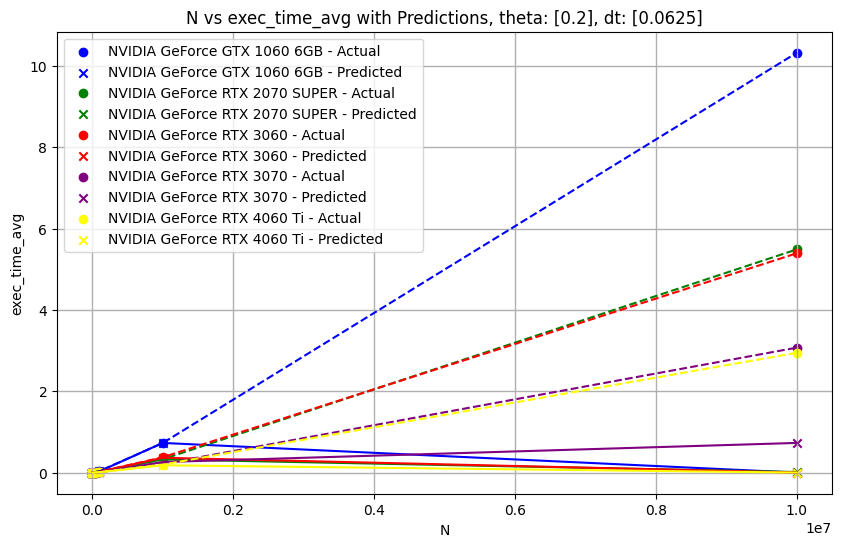

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = f_full.copy()
model = model_poly_final

# src = 'theta'
src = 'N'
target = 'exec_time_avg'

# Define the filter criteria
filter_criteria = {
    # 'N': [10000000],
    'theta': [0.2],
    'dt': [0.0625]
}

# Apply filtering based on the filter criteria
for feature, values in filter_criteria.items():
    df = df[df[feature].isin(values)]

# Add predictions to the filtered dataset
df['predicted_exec_time_avg'] = model.predict(df[selected_features])

# Group by a specific feature
grouped = df.groupby('Name')

# Plot X vs y for each group
colors = ['blue', 'green', 'red', 'purple', 'yellow']  # Specify colors for each group if known

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot X vs y with scatter points and connect them with dashed lines for each group
for (group_name, group_data), color in zip(grouped, colors):
    # Plot actual values
    ax.scatter(group_data[src], group_data[target], color=color, label=f'{group_name} - Actual')
    ax.plot(group_data[src], group_data[target], linestyle='--', color=color)  # Dashed line
    
    # Plot predicted values
    ax.scatter(group_data[src], group_data['predicted_exec_time_avg'], color=color, marker='x', label=f'{group_name} - Predicted')
    ax.plot(group_data[src], group_data['predicted_exec_time_avg'], linestyle='-', color=color)  # Solid line for predicted

# Add grid and logarithmic scales
ax.grid(linestyle='-', linewidth=1)
# ax.set_yscale("asinh")         # Logarithmic scale for y-axis

# Add labels, title, and legend
ax.set_xlabel(src)
ax.set_ylabel(target)
ax.set_title(f'{src} vs {target} with Predictions, theta: [0.2], dt: [0.0625]')
ax.legend()

# Set x and y limits to cover the range of points
# ax.set_xlim(df['I'].min() - 1, df['I'].max() + 1)
# ax.set_ylim(df['accumulated_error'].min() * 0.8, df['accumulated_error'].max() * 1.2)

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_poly_final = clone(model_poly)

model_params, selected_features = load_best_params_and_features("CV_results/Ridge_Random_CV_results_1.json")
target_feature = 'exec_time_avg'

X_train, X_test, y_train, y_test = train_test_split(f_full[selected_features], f_full[target_feature], test_size=0.2, random_state=42)

model_poly_final.set_params(**model_params)
model_poly_final.fit(X_train, y_train)

display(model_poly_final)

# Predict and inverse transform the predictions
y_pred = model_poly_final.predict(X_test)

# Evaluate
mae = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")



In [ ]:
from sklearn.base import clone
from sklearn.metrics import mean_absolute_percentage_error

# Clone the model
model_poly_final = clone(model_poly)

# Load model parameters and selected features
model_params, selected_features = load_best_params_and_features("CV_results/input+GPU/Ridge_Random_CV_results_1.json")
target_feature = 'exec_time_avg'

# Filter training and testing data based on the N threshold
N_threshold = 1000000
train_mask = f_full['N'] <= N_threshold  # Training: N <= 10000
test_mask = f_full['N'] > N_threshold    # Testing: N > 10000

X_train = f_full[train_mask][selected_features]
y_train = f_full[train_mask][target_feature]

X_test = f_full[test_mask][selected_features]
y_test = f_full[test_mask][target_feature]

# Fit the model with the loaded parameters
model_poly_final.set_params(**model_params)
model_poly_final.fit(X_train, y_train)

display(model_poly_final)

# Predict and evaluate
y_pred = model_poly_final.predict(X_test)
mae = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")


Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 1, 'regressor__poly__degree': 5}
Selected Features: ['N', 'theta', 'dt', 'Clock Rate (MHz)', 'L2 Cache Size (KB)', 'Half Precision FLOP/s']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      PowerTransformer()),
                                                     ('poly',
                                                      PolynomialFeatures(degree=5)),
                                                     ('model',
                                                      Ridge(alpha=1))]),
                           transformer=QuantileTransformer())

Mean Absolute Error: 0.944340


# MAS SAMPLES DE N CON MENOS INTERVALOS (cada 1000 como caso de precision) Mencionar que al no tener mucha importancia el perfilado de gpu, se puede enfocar el tiempo extra tomado por esto para obtener mas samples de los modelos

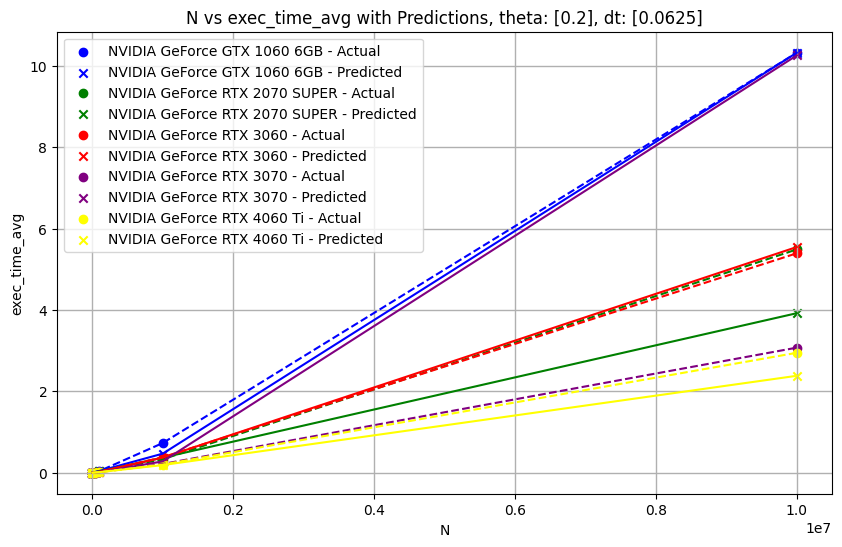

In [32]:
### compare against model
import pandas as pd
import matplotlib.pyplot as plt

df = f_full.copy()
model = best_model

# src = 'theta'
src = 'N'
target = 'exec_time_avg'

# Define the filter criteria
filter_criteria = {
    # 'N': [10000000],
    'theta': [0.2],
    'dt': [0.0625]
}

# Apply filtering based on the filter criteria
for feature, values in filter_criteria.items():
    df = df[df[feature].isin(values)]

# Add predictions to the filtered dataset
df['predicted_exec_time_avg'] = model.predict(df[input_features])

# Group by a specific feature
grouped = df.groupby('Name')

# Plot X vs y for each group
colors = ['blue', 'green', 'red', 'purple', 'yellow']  # Specify colors for each group if known

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot X vs y with scatter points and connect them with dashed lines for each group
for (group_name, group_data), color in zip(grouped, colors):
    # Plot actual values
    ax.scatter(group_data[src], group_data[target], color=color, label=f'{group_name} - Actual')
    ax.plot(group_data[src], group_data[target], linestyle='--', color=color)  # Dashed line
    
    # Plot predicted values
    ax.scatter(group_data[src], group_data['predicted_exec_time_avg'], color=color, marker='x', label=f'{group_name} - Predicted')
    ax.plot(group_data[src], group_data['predicted_exec_time_avg'], linestyle='-', color=color)  # Solid line for predicted

# Add grid and logarithmic scales
ax.grid(linestyle='-', linewidth=1)
# ax.set_yscale("asinh")         # Logarithmic scale for y-axis

# Add labels, title, and legend
ax.set_xlabel(src)
ax.set_ylabel(target)
ax.set_title(f'{src} vs {target} with Predictions, theta: [0.2], dt: [0.0625]')
ax.legend()

# Set x and y limits to cover the range of points
# ax.set_xlim(df['I'].min() - 1, df['I'].max() + 1)
# ax.set_ylim(df['accumulated_error'].min() * 0.8, df['accumulated_error'].max() * 1.2)

plt.show()